<a href="https://colab.research.google.com/github/Gowthersan/FaceEmotionsReconation/blob/main/Neural_Network_for_Digit_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import os
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuration pour de meilleurs graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [6]:
class AdvancedDigitRecognitionCNN:
    def __init__(self, input_shape=(28, 28, 1), num_classes=10):
        """
        Système avancé de reconnaissance de chiffres avec visualisations complètes

        Args:
            input_shape: Forme des images d'entrée (hauteur, largeur, canaux)
            num_classes: Nombre de classes (0-9 pour les chiffres)
        """
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.history = None
        self.data_info = {}

    def analyze_dataset(self, x_data, y_data, dataset_name="Dataset"):
        """
        Analyse complète et visualisation du dataset
        """
        print(f"=== ANALYSE DU {dataset_name.upper()} ===")

        # Informations générales
        print(f"Forme des données: {x_data.shape}")
        print(f"Forme des labels: {y_data.shape}")
        print(f"Type des données: {x_data.dtype}")
        print(f"Plage des valeurs: [{x_data.min():.3f}, {x_data.max():.3f}]")
        print(f"Mémoire utilisée: {x_data.nbytes / (1024**2):.2f} MB")

        # Statistiques des classes
        class_counts = Counter(y_data)
        print(f"Distribution des classes: {dict(class_counts)}")

        # Stocker les informations
        self.data_info[dataset_name] = {
            'shape': x_data.shape,
            'dtype': x_data.dtype,
            'range': (x_data.min(), x_data.max()),
            'class_distribution': class_counts,
            'memory_mb': x_data.nbytes / (1024**2)
        }

        # Visualisations
        self._plot_dataset_overview(x_data, y_data, dataset_name)
        self._plot_class_distribution(y_data, dataset_name)
        self._plot_pixel_statistics(x_data, dataset_name)
        self._plot_sample_images(x_data, y_data, dataset_name)

    def _plot_dataset_overview(self, x_data, y_data, dataset_name):
        """
        Vue d'ensemble du dataset avec statistiques
        """
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(f'Vue d\'ensemble du {dataset_name}', fontsize=16, fontweight='bold')

        # Distribution des intensités de pixels
        pixel_values = x_data.flatten()
        axes[0, 0].hist(pixel_values, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0, 0].set_title('Distribution des intensités de pixels')
        axes[0, 0].set_xlabel('Intensité')
        axes[0, 0].set_ylabel('Fréquence')
        axes[0, 0].grid(True, alpha=0.3)

        # Statistiques par image
        mean_per_image = np.mean(x_data, axis=(1, 2, 3) if len(x_data.shape) == 4 else (1, 2))
        std_per_image = np.std(x_data, axis=(1, 2, 3) if len(x_data.shape) == 4 else (1, 2))

        axes[0, 1].scatter(mean_per_image, std_per_image, alpha=0.6, c=y_data, cmap='tab10')
        axes[0, 1].set_title('Moyenne vs Écart-type par image')
        axes[0, 1].set_xlabel('Moyenne des pixels')
        axes[0, 1].set_ylabel('Écart-type des pixels')
        axes[0, 1].grid(True, alpha=0.3)

        # Boxplot des intensités par classe
        df_pixels = pd.DataFrame({
            'classe': np.repeat(y_data, x_data.shape[1] * x_data.shape[2]),
            'intensite': x_data.reshape(-1)
        })
        sns.boxplot(data=df_pixels, x='classe', y='intensite', ax=axes[0, 2])
        axes[0, 2].set_title('Distribution des intensités par classe')
        axes[0, 2].set_ylabel('Intensité des pixels')

        # Matrice de corrélation des moyennes par classe
        class_means = []
        for i in range(self.num_classes):
            class_mask = y_data == i
            if np.any(class_mask):
                class_mean = np.mean(x_data[class_mask], axis=0)
                class_means.append(class_mean.flatten())

        if len(class_means) > 1:
            corr_matrix = np.corrcoef(class_means)
            im = axes[1, 0].imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
            axes[1, 0].set_title('Corrélation entre classes (moyennes)')
            axes[1, 0].set_xlabel('Classe')
            axes[1, 0].set_ylabel('Classe')
            plt.colorbar(im, ax=axes[1, 0])

        # Heatmap des moyennes par classe
        if len(class_means) > 0:
            class_means_reshaped = [cm.reshape(self.input_shape[:2]) for cm in class_means]
            combined_heatmap = np.hstack(class_means_reshaped[:5])  # Premières 5 classes
            im2 = axes[1, 1].imshow(combined_heatmap, cmap='viridis')
            axes[1, 1].set_title('Patterns moyens par classe (0-4)')
            axes[1, 1].set_xticks(range(0, combined_heatmap.shape[1], self.input_shape[1]))
            axes[1, 1].set_xticklabels(range(5))
            plt.colorbar(im2, ax=axes[1, 1])

        # Statistiques de forme
        stats_text = f"""
        Nombre d'images: {x_data.shape[0]:,}
        Résolution: {x_data.shape[1]}x{x_data.shape[2]}
        Canaux: {x_data.shape[3] if len(x_data.shape) == 4 else 1}
        Classes uniques: {len(np.unique(y_data))}

        Statistiques globales:
        Moyenne: {np.mean(x_data):.4f}
        Médiane: {np.median(x_data):.4f}
        Écart-type: {np.std(x_data):.4f}
        """
        axes[1, 2].text(0.1, 0.9, stats_text, transform=axes[1, 2].transAxes,
                        verticalalignment='top', fontfamily='monospace',
                        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        axes[1, 2].set_xlim(0, 1)
        axes[1, 2].set_ylim(0, 1)
        axes[1, 2].axis('off')
        axes[1, 2].set_title('Statistiques détaillées')

        plt.tight_layout()
        plt.show()

    def _plot_class_distribution(self, y_data, dataset_name):
        """
        Visualisation détaillée de la distribution des classes
        """
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle(f'Distribution des classes - {dataset_name}', fontsize=14, fontweight='bold')

        class_counts = Counter(y_data)
        classes = list(range(self.num_classes))
        counts = [class_counts.get(i, 0) for i in classes]

        # Graphique en barres
        bars = axes[0].bar(classes, counts, color=sns.color_palette("husl", self.num_classes))
        axes[0].set_title('Distribution par classe')
        axes[0].set_xlabel('Classe (Chiffre)')
        axes[0].set_ylabel('Nombre d\'échantillons')
        axes[0].grid(True, alpha=0.3)

        # Ajouter les valeurs sur les barres
        for bar, count in zip(bars, counts):
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                        str(count), ha='center', va='bottom')

        # Graphique circulaire
        axes[1].pie(counts, labels=classes, autopct='%1.1f%%',
                   colors=sns.color_palette("husl", self.num_classes))
        axes[1].set_title('Répartition en pourcentages')

        # Analyse du déséquilibre
        mean_count = np.mean(counts)
        imbalance_ratios = [count / mean_count for count in counts]

        bars2 = axes[2].bar(classes, imbalance_ratios,
                           color=['red' if ratio < 0.8 else 'orange' if ratio < 1.2 else 'green'
                                 for ratio in imbalance_ratios])
        axes[2].axhline(y=1.0, color='black', linestyle='--', alpha=0.7, label='Équilibre parfait')
        axes[2].set_title('Ratio de déséquilibre des classes')
        axes[2].set_xlabel('Classe')
        axes[2].set_ylabel('Ratio (classe/moyenne)')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Afficher les statistiques
        print(f"Classe majoritaire: {max(class_counts, key=class_counts.get)} ({max(counts)} échantillons)")
        print(f"Classe minoritaire: {min(class_counts, key=class_counts.get)} ({min(counts)} échantillons)")
        print(f"Ratio déséquilibre: {max(counts)/min(counts):.2f}:1")

    def _plot_pixel_statistics(self, x_data, dataset_name):
        """
        Analyse statistique avancée des pixels
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'Analyse statistique des pixels - {dataset_name}', fontsize=14, fontweight='bold')

        # Moyenne et écart-type par position de pixel
        mean_image = np.mean(x_data, axis=0)
        std_image = np.std(x_data, axis=0)

        if len(mean_image.shape) == 3:
            mean_image = mean_image[:, :, 0]
            std_image = std_image[:, :, 0]

        # Heatmap de la moyenne
        im1 = axes[0, 0].imshow(mean_image, cmap='viridis')
        axes[0, 0].set_title('Intensité moyenne par pixel')
        plt.colorbar(im1, ax=axes[0, 0])

        # Heatmap de l'écart-type
        im2 = axes[0, 1].imshow(std_image, cmap='plasma')
        axes[0, 1].set_title('Écart-type par pixel')
        plt.colorbar(im2, ax=axes[0, 1])

        # Distribution cumulative
        pixel_values = x_data.flatten()
        sorted_pixels = np.sort(pixel_values)
        cumulative = np.arange(1, len(sorted_pixels) + 1) / len(sorted_pixels)

        axes[1, 0].plot(sorted_pixels, cumulative, linewidth=2)
        axes[1, 0].set_title('Fonction de répartition cumulative')
        axes[1, 0].set_xlabel('Intensité des pixels')
        axes[1, 0].set_ylabel('Probabilité cumulative')
        axes[1, 0].grid(True, alpha=0.3)

        # Q-Q plot pour normalité
        from scipy import stats
        stats.probplot(pixel_values[::1000], dist="norm", plot=axes[1, 1])  # Échantillonnage pour performance
        axes[1, 1].set_title('Q-Q Plot (test de normalité)')
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def _plot_sample_images(self, x_data, y_data, dataset_name, n_samples=20):
        """
        Affichage d'échantillons représentatifs du dataset
        """
        fig, axes = plt.subplots(4, 10, figsize=(20, 8))
        fig.suptitle(f'Échantillons du {dataset_name}', fontsize=14, fontweight='bold')

        # Échantillons aléatoires
        indices = np.random.choice(len(x_data), n_samples, replace=False)

        for i, idx in enumerate(indices):
            row, col = i // 10, i % 10
            img = x_data[idx]
            if len(img.shape) == 3 and img.shape[-1] == 1:
                img = img[:, :, 0]

            axes[row, col].imshow(img, cmap='gray')
            axes[row, col].set_title(f'Classe: {y_data[idx]}', fontsize=10)
            axes[row, col].axis('off')

        # Échantillons par classe (2 dernières lignes)
        class_samples = []
        for class_id in range(self.num_classes):
            class_indices = np.where(y_data == class_id)[0]
            if len(class_indices) > 0:
                sample_idx = np.random.choice(class_indices)
                class_samples.append((sample_idx, class_id))

        for i, (idx, class_id) in enumerate(class_samples):
            if i < 20:
                row = 2 + (i // 10)
                col = i % 10
                img = x_data[idx]
                if len(img.shape) == 3 and img.shape[-1] == 1:
                    img = img[:, :, 0]

                axes[row, col].imshow(img, cmap='gray')
                axes[row, col].set_title(f'Classe {class_id}', fontsize=10, color='red')
                axes[row, col].axis('off')

        plt.tight_layout()
        plt.show()

    def create_data_augmentation(self, rotation_range=10, width_shift_range=0.1,
                               height_shift_range=0.1, zoom_range=0.1,
                               horizontal_flip=False):
        """
        Crée un générateur d'augmentation de données avancé
        """
        datagen = ImageDataGenerator(
            rotation_range=rotation_range,
            width_shift_range=width_shift_range,
            height_shift_range=height_shift_range,
            zoom_range=zoom_range,
            horizontal_flip=horizontal_flip,
            fill_mode='nearest',
            brightness_range=[0.8, 1.2],
            channel_shift_range=0.1
        )

        return datagen

    def visualize_augmentation(self, x_data, y_data, n_examples=5):
        """
        Visualise les effets de l'augmentation de données
        """
        datagen = self.create_data_augmentation()

        fig, axes = plt.subplots(n_examples, 6, figsize=(18, 3*n_examples))
        fig.suptitle('Exemples d\'augmentation de données', fontsize=14, fontweight='bold')

        for i in range(n_examples):
            # Image originale
            idx = np.random.randint(0, len(x_data))
            img = x_data[idx:idx+1]
            label = y_data[idx]

            axes[i, 0].imshow(img[0, :, :, 0] if len(img.shape) == 4 else img[0], cmap='gray')
            axes[i, 0].set_title(f'Original\nClasse: {label}')
            axes[i, 0].axis('off')

            # Images augmentées
            augmented_images = datagen.flow(img, batch_size=1)
            for j in range(1, 6):
                aug_img = next(augmented_images)
                axes[i, j].imshow(aug_img[0, :, :, 0] if len(aug_img.shape) == 4 else aug_img[0], cmap='gray')
                axes[i, j].set_title(f'Augmentée {j}')
                axes[i, j].axis('off')

        plt.tight_layout()
        plt.show()

    def build_basic_cnn(self):
        """
        CNN de base optimisé
        """
        model = keras.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.25),

            layers.GlobalAveragePooling2D(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def build_resnet_model(self):
        """
        Architecture ResNet adaptée pour les chiffres
        """
        def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False, name=None):
            bn_axis = 3

            if conv_shortcut:
                shortcut = layers.Conv2D(filters, 1, strides=stride, name=name + '_0_conv')(x)
                shortcut = layers.BatchNormalization(axis=bn_axis, name=name + '_0_bn')(shortcut)
            else:
                shortcut = x

            x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', name=name + '_1_conv')(x)
            x = layers.BatchNormalization(axis=bn_axis, name=name + '_1_bn')(x)
            x = layers.Activation('relu', name=name + '_1_relu')(x)

            x = layers.Conv2D(filters, kernel_size, padding='same', name=name + '_2_conv')(x)
            x = layers.BatchNormalization(axis=bn_axis, name=name + '_2_bn')(x)

            x = layers.Add(name=name + '_add')([shortcut, x])
            x = layers.Activation('relu', name=name + '_out')(x)
            return x

        inputs = keras.Input(shape=self.input_shape)

        x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

        x = residual_block(x, 64, conv_shortcut=True, name='conv2_block1')
        x = residual_block(x, 64, name='conv2_block2')

        x = residual_block(x, 128, stride=2, conv_shortcut=True, name='conv3_block1')
        x = residual_block(x, 128, name='conv3_block2')

        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)

        model = keras.Model(inputs, outputs)
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def build_efficientnet_model(self):
        """
        Modèle basé sur EfficientNet pour images complexes
        """
        # Adapter l'input pour EfficientNet (minimum 32x32)
        inputs = keras.Input(shape=self.input_shape)

        if self.input_shape[0] < 32:
            # Upsampling pour les petites images
            x = layers.UpSampling2D(size=(2, 2))(inputs)
            if self.input_shape[-1] == 1:
                # Convertir en RGB pour EfficientNet
                x = layers.Conv2D(3, 1, padding='same')(x)
        else:
            x = inputs
            if self.input_shape[-1] == 1:
                x = layers.Conv2D(3, 1, padding='same')(x)

        # EfficientNetB0 comme base
        base_model = applications.EfficientNetB0(
            weights='imagenet',
            include_top=False,
            input_tensor=x
        )

        # Congeler les couches de base pour le fine-tuning
        base_model.trainable = False

        # Ajouter des couches personnalisées
        x = base_model.output
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)

        model = keras.Model(inputs, outputs)
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def fine_tune_efficientnet(self, model, unfreeze_layers=50):
        """
        Fine-tuning du modèle EfficientNet
        """
        # Décongeler les dernières couches
        model.layers[1].trainable = True  # base_model

        # Congeler toutes les couches sauf les dernières
        for layer in model.layers[1].layers[:-unfreeze_layers]:
            layer.trainable = False

        # Recompiler avec un taux d'apprentissage plus faible
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.00001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def preprocess_image(self, image_path_or_array, target_size=(28, 28)):
        """
        Préprocessing avancé d'images avec visualisation
        """
        # Charger l'image
        if isinstance(image_path_or_array, str):
            img = cv2.imread(image_path_or_array)
            if img is None:
                raise ValueError(f"Impossible de charger l'image: {image_path_or_array}")
        else:
            img = image_path_or_array.copy()

        # Étapes de préprocessing avec visualisation
        steps = []

        # 1. Original
        steps.append(("Original", img.copy()))

        # 2. Conversion en niveaux de gris
        if len(img.shape) == 3:
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            img_gray = img.copy()
        steps.append(("Niveaux de gris", img_gray))

        # 3. Réduction du bruit
        img_denoised = cv2.bilateralFilter(img_gray, 9, 75, 75)
        steps.append(("Débruité", img_denoised))

        # 4. Amélioration du contraste (CLAHE)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_enhanced = clahe.apply(img_denoised)
        steps.append(("Contraste amélioré", img_enhanced))

        # 5. Redimensionnement
        img_resized = cv2.resize(img_enhanced, target_size, interpolation=cv2.INTER_AREA)
        steps.append(("Redimensionné", img_resized))

        # 6. Normalisation
        img_normalized = img_resized.astype('float32') / 255.0
        steps.append(("Normalisé", img_normalized))

        # 7. Inversion si nécessaire
        if np.mean(img_normalized) > 0.5:
            img_normalized = 1.0 - img_normalized
            steps.append(("Inversé", img_normalized))

        # Visualisation des étapes
        self._visualize_preprocessing_steps(steps)

        # Préparation pour le modèle
        img_processed = img_normalized.reshape(1, target_size[0], target_size[1], 1)

        return img_processed

    def _visualize_preprocessing_steps(self, steps):
        """
        Visualise toutes les étapes du préprocessing
        """
        n_steps = len(steps)
        cols = min(4, n_steps)
        rows = (n_steps + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
        fig.suptitle('Étapes du préprocessing', fontsize=14, fontweight='bold')

        if rows == 1:
            axes = axes.reshape(1, -1)

        for i, (title, img) in enumerate(steps):
            row, col = i // cols, i % cols

            if len(img.shape) == 3:
                axes[row, col].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            else:
                axes[row, col].imshow(img, cmap='gray')

            axes[row, col].set_title(title)
            axes[row, col].axis('off')

        # Mask unused axes
        for i in range(n_steps, rows * cols):
            row, col = i // cols, i % cols
            axes[row, col].axis('off')

        plt.tight_layout()
        plt.show()

    def train_with_custom_dataset(self, custom_x, custom_y, base_model,
                                 validation_split=0.2, epochs=20):
        """
        Fine-tuning avec un dataset personnalisé
        """
        print("=== ENTRAÎNEMENT AVEC DATASET PERSONNALISÉ ===")

        # Analyser le dataset personnalisé
        self.analyze_dataset(custom_x, custom_y, "Dataset Personnalisé")

        # Séparer train/validation
        x_train, x_val, y_train, y_val = train_test_split(
            custom_x, custom_y, test_size=validation_split,
            stratify=custom_y, random_state=42
        )

        # Augmentation de données
        datagen = self.create_data_augmentation()
        self.visualize_augmentation(x_train, y_train)

        # Configuration pour le fine-tuning
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=10,
                restore_best_weights=True
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-8
            ),
            keras.callbacks.ModelCheckpoint(
                'best_custom_model.h5',
                monitor='val_accuracy',
                save_best_only=True
            )
        ]

        # Entraînement avec augmentation
        history = base_model.fit(
            datagen.flow(x_train, y_train, batch_size=32),
            steps_per_epoch=len(x_train) // 32,
            epochs=epochs,
            validation_data=(x_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

        self.model = base_model
        self.history = history

        return history

    def comprehensive_evaluation(self, x_test, y_test, dataset_name="Test"):
        """
        Évaluation complète avec toutes les métriques et visualisations
        """
        if self.model is None:
            raise ValueError("Le modèle doit être entraîné avant l'évaluation")

        print(f"=== ÉVALUATION COMPLÈTE - {dataset_name.upper()} ===")

        # Prédictions
        y_pred_proba = self.model.predict(x_test, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)

        # Métriques de base
        # Check if 'top_3_accuracy' is in the model's metrics
        if 'top_3_accuracy' in self.model.metrics_names:
            test_loss, test_accuracy, test_top3 = self.model.evaluate(x_test, y_test, verbose=0)
            print(f"Top-3 Précision: {test_top3:.4f}")
        else:
            test_loss, test_accuracy = self.model.evaluate(x_test, y_test, verbose=0)

        print(f"Perte: {test_loss:.4f}")
        print(f"Précision: {test_accuracy:.4f}")


        # Rapport de classification
        print("\nRapport de classification:")
        print(classification_report(y_test, y_pred, target_names=[str(i) for i in range(self.num_classes)]))

        # Visualisations complètes
        self._plot_confusion_matrix(y_test, y_pred, dataset_name)
        self._plot_prediction_confidence(y_test, y_pred_proba, dataset_name)
        self._plot_error_analysis(x_test, y_test, y_pred, y_pred_proba, dataset_name)
        self._plot_class_performance(y_test, y_pred, y_pred_proba, dataset_name)

        return {
            'accuracy': test_accuracy,
            'loss': test_loss,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }

    def _plot_confusion_matrix(self, y_true, y_pred, dataset_name):
        """
        Matrice de confusion avancée avec plusieurs visualisations
        """
        cm = confusion_matrix(y_true, y_pred)

        fig, axes = plt.subplots(1, 3, figsize=(20, 6))
        fig.suptitle(f'Matrices de confusion - {dataset_name}', fontsize=14, fontweight='bold')

        # Matrice de confusion absolue
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
        axes[0].set_title('Valeurs absolues')
        axes[0].set_xlabel('Prédictions')
        axes[0].set_ylabel('Vraies valeurs')

        # Matrice de confusion normalisée (par ligne)
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Oranges', ax=axes[1])
        axes[1].set_title('Normalisée par vraie classe')
        axes[1].set_xlabel('Prédictions')
        axes[1].set_ylabel('Vraies valeurs')

        # Matrice de confusion normalisée (par colonne)
        cm_norm_pred = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
        sns.heatmap(cm_norm_pred, annot=True, fmt='.2f', cmap='Greens', ax=axes[2])
        axes[2].set_title('Normalisée par prédiction')
        axes[2].set_xlabel('Prédictions')
        axes[2].set_ylabel('Vraies valeurs')

        plt.tight_layout()
        plt.show()

    def _plot_prediction_confidence(self, y_true, y_pred_proba, dataset_name):
        """
        Analyse de la confiance des prédictions
        """
        y_pred = np.argmax(y_pred_proba, axis=1)
        confidence = np.max(y_pred_proba, axis=1)
        correct = (y_true == y_pred)

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'Analyse de confiance - {dataset_name}', fontsize=14, fontweight='bold')

        # Distribution de confiance pour prédictions correctes vs incorrectes
        axes[0, 0].hist(confidence[correct], bins=50, alpha=0.7, label='Correctes', color='green')
        axes[0, 0].hist(confidence[~correct], bins=50, alpha=0.7, label='Incorrectes', color='red')
        axes[0, 0].set_title('Distribution de confiance')
        axes[0, 0].set_xlabel('Confiance')
        axes[0, 0].set_ylabel('Fréquence')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Confiance par classe
        conf_by_class = []
        for i in range(self.num_classes):
            mask = y_true == i
            if np.any(mask):
                conf_by_class.append(confidence[mask])

        axes[0, 1].boxplot(conf_by_class, labels=range(self.num_classes))
        axes[0, 1].set_title('Confiance par classe')
        axes[0, 1].set_xlabel('Classe')
        axes[0, 1].set_ylabel('Confiance')
        axes[0, 1].grid(True, alpha=0.3)

        # Courbe de calibration
        from sklearn.calibration import calibration_curve
        fraction_of_positives, mean_predicted_value = calibration_curve(
            correct.astype(int), confidence, n_bins=10
        )

        axes[1, 0].plot(mean_predicted_value, fraction_of_positives, "s-", label="Modèle")
        axes[1, 0].plot([0, 1], [0, 1], "k:", label="Calibration parfaite")
        axes[1, 0].set_title('Courbe de calibration')
        axes[1, 0].set_xlabel('Confiance moyenne')
        axes[1, 0].set_ylabel('Fraction de positifs')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # Précision par seuil de confiance
        thresholds = np.linspace(0, 1, 21)
        precisions = []
        coverages = []

        for thresh in thresholds:
            mask = confidence >= thresh
            if np.any(mask):
                precision = np.mean(correct[mask])
                coverage = np.mean(mask)
            else:
                precision = 0
                coverage = 0
            precisions.append(precision)
            coverages.append(coverage)

        ax2 = axes[1, 1]
        ax3 = ax2.twinx()

        line1 = ax2.plot(thresholds, precisions, 'b-', label='Précision')
        line2 = ax3.plot(thresholds, coverages, 'r-', label='Couverture')

        ax2.set_xlabel('Seuil de confiance')
        ax2.set_ylabel('Précision', color='b')
        ax3.set_ylabel('Couverture', color='r')
        ax2.set_title('Précision vs Couverture')

        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax2.legend(lines, labels, loc='center right')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def _plot_error_analysis(self, x_test, y_true, y_pred, y_pred_proba, dataset_name):
        """
        Analyse détaillée des erreurs
        """
        errors = y_true != y_pred
        error_indices = np.where(errors)[0]

        if len(error_indices) == 0:
            print("Aucune erreur trouvée!")
            return

        # Sélectionner les erreurs les plus confiantes (faux positifs sûrs)
        error_confidences = np.max(y_pred_proba[error_indices], axis=1)
        top_error_indices = error_indices[np.argsort(error_confidences)[-20:]]

        fig, axes = plt.subplots(4, 5, figsize=(20, 16))
        fig.suptitle(f'Analyse des erreurs - {dataset_name}', fontsize=14, fontweight='bold')

        for i, idx in enumerate(top_error_indices):
            row, col = i // 5, i % 5

            img = x_test[idx]
            if len(img.shape) == 3 and img.shape[-1] == 1:
                img = img[:, :, 0]

            axes[row, col].imshow(img, cmap='gray')

            true_label = y_true[idx]
            pred_label = y_pred[idx]
            confidence = np.max(y_pred_proba[idx])

            title = f'V:{true_label} P:{pred_label}\nConf:{confidence:.3f}'
            axes[row, col].set_title(title, fontsize=10,
                                   color='red' if confidence > 0.8 else 'orange')
            axes[row, col].axis('off')

        plt.tight_layout()
        plt.show()

        # Statistiques des erreurs
        print(f"Nombre total d'erreurs: {len(error_indices)} ({100*len(error_indices)/len(y_true):.2f}%)")

        # Erreurs par classe
        error_by_class = {}
        for i in range(self.num_classes):
            true_class_mask = y_true == i
            class_errors = errors[true_class_mask]
            if len(class_errors) > 0:
                error_rate = np.mean(class_errors)
                error_by_class[i] = error_rate

        print("\nTaux d'erreur par classe:")
        for class_id, error_rate in sorted(error_by_class.items(), key=lambda x: x[1], reverse=True):
            print(f"  Classe {class_id}: {error_rate:.3f}")

    def _plot_class_performance(self, y_true, y_pred, y_pred_proba, dataset_name):
        """
        Performance détaillée par classe
        """
        from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

        precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'Performance par classe - {dataset_name}', fontsize=14, fontweight='bold')

        # Métriques par classe
        x = np.arange(self.num_classes)
        width = 0.25

        axes[0, 0].bar(x - width, precision, width, label='Précision', alpha=0.8)
        axes[0, 0].bar(x, recall, width, label='Rappel', alpha=0.8)
        axes[0, 0].bar(x + width, f1, width, label='F1-Score', alpha=0.8)

        axes[0, 0].set_title('Métriques par classe')
        axes[0, 0].set_xlabel('Classe')
        axes[0, 0].set_ylabel('Score')
        axes[0, 0].set_xticks(x)
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Support par classe
        bars = axes[0, 1].bar(x, support, color=sns.color_palette("husl", self.num_classes))
        axes[0, 1].set_title('Nombre d\'échantillons par classe')
        axes[0, 1].set_xlabel('Classe')
        axes[0, 1].set_ylabel('Nombre d\'échantillons')
        axes[0, 1].grid(True, alpha=0.3)

        # Ajouter les valeurs sur les barres
        for bar, val in zip(bars, support):
            axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(support)*0.01,
                           str(val), ha='center', va='bottom')

        # Courbes ROC (pour classification multi-classe)
        if self.num_classes <= 10:  # Éviter trop de courbes
            y_true_bin = keras.utils.to_categorical(y_true, self.num_classes)

            for i in range(min(5, self.num_classes)):  # Première 5 classes seulement
                fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
                roc_auc = auc(fpr, tpr)
                axes[1, 0].plot(fpr, tpr, label=f'Classe {i} (AUC = {roc_auc:.2f})')

            axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
            axes[1, 0].set_title('Courbes ROC (premières 5 classes)')
            axes[1, 0].set_xlabel('Taux de faux positifs')
            axes[1, 0].set_ylabel('Taux de vrais positifs')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)

        # Heatmap des confusions les plus fréquentes
        cm = confusion_matrix(y_true, y_pred)

        # Trouver les confusions les plus fréquentes (hors diagonale)
        cm_errors = cm.copy()
        np.fill_diagonal(cm_errors, 0)

        # Normaliser par le nombre total de chaque vraie classe
        cm_errors_norm = cm_errors.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        sns.heatmap(cm_errors_norm, annot=True, fmt='.3f', cmap='Reds', ax=axes[1, 1])
        axes[1, 1].set_title('Taux de confusion entre classes')
        axes[1, 1].set_xlabel('Classe prédite')
        axes[1, 1].set_ylabel('Vraie classe')

        plt.tight_layout()
        plt.show()

    def plot_training_history(self):
        """
        Visualisation complète de l'historique d'entraînement
        """
        if self.history is None:
            print("Aucun historique d'entraînement disponible")
            return

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Historique d\'entraînement complet', fontsize=16, fontweight='bold')

        history = self.history.history
        epochs = range(1, len(history['accuracy']) + 1)

        # Précision
        axes[0, 0].plot(epochs, history['accuracy'], 'b-', label='Entraînement', linewidth=2)
        axes[0, 0].plot(epochs, history['val_accuracy'], 'r-', label='Validation', linewidth=2)
        axes[0, 0].set_title('Précision du modèle')
        axes[0, 0].set_xlabel('Époque')
        axes[0, 0].set_ylabel('Précision')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].set_ylim([0, 1])

        # Perte
        axes[0, 1].plot(epochs, history['loss'], 'b-', label='Entraînement', linewidth=2)
        axes[0, 1].plot(epochs, history['val_loss'], 'r-', label='Validation', linewidth=2)
        axes[0, 1].set_title('Perte du modèle')
        axes[0, 1].set_xlabel('Époque')
        axes[0, 1].set_ylabel('Perte')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Top-3 Accuracy
        if 'top_3_accuracy' in history:
            axes[0, 2].plot(epochs, history['top_3_accuracy'], 'b-', label='Entraînement', linewidth=2)
            axes[0, 2].plot(epochs, history['val_top_3_accuracy'], 'r-', label='Validation', linewidth=2)
            axes[0, 2].set_title('Top-3 Précision')
            axes[0, 2].set_xlabel('Époque')
            axes[0, 2].set_ylabel('Top-3 Précision')
            axes[0, 2].legend()
            axes[0, 2].grid(True, alpha=0.3)
            axes[0, 2].set_ylim([0, 1])

        # Taux d'apprentissage (si disponible)
        if 'lr' in history:
            axes[1, 0].semilogy(epochs, history['lr'], 'g-', linewidth=2)
            axes[1, 0].set_title('Taux d\'apprentissage')
            axes[1, 0].set_xlabel('Époque')
            axes[1, 0].set_ylabel('Taux d\'apprentissage (log)')
            axes[1, 0].grid(True, alpha=0.3)

        # Écart entre train et validation
        train_val_gap = np.array(history['accuracy']) - np.array(history['val_accuracy'])
        axes[1, 1].plot(epochs, train_val_gap, 'purple', linewidth=2)
        axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[1, 1].set_title('Écart Train-Validation (Surapprentissage)')
        axes[1, 1].set_xlabel('Époque')
        axes[1, 1].set_ylabel('Différence de précision')
        axes[1, 1].grid(True, alpha=0.3)

        # Stabilité de l'entraînement (variance mobile)
        window_size = min(5, len(history['val_loss']) // 3)
        if window_size > 1:
            val_loss_smooth = pd.Series(history['val_loss']).rolling(window=window_size).std()
            axes[1, 2].plot(epochs, val_loss_smooth, 'orange', linewidth=2)
            axes[1, 2].set_title('Stabilité (Écart-type mobile de la perte)')
            axes[1, 2].set_xlabel('Époque')
            axes[1, 2].set_ylabel('Écart-type mobile')
            axes[1, 2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Afficher les statistiques finales
        final_epoch = len(history['accuracy'])
        print(f"\n=== STATISTIQUES FINALES (Époque {final_epoch}) ===")
        print(f"Précision d'entraînement: {history['accuracy'][-1]:.4f}")
        print(f"Précision de validation: {history['val_accuracy'][-1]:.4f}")
        print(f"Perte d'entraînement: {history['loss'][-1]:.4f}")
        print(f"Perte de validation: {history['val_loss'][-1]:.4f}")
        if 'top_3_accuracy' in history:
            print(f"Top-3 Précision validation: {history['val_top_3_accuracy'][-1]:.4f}")

        # Détection du surapprentissage
        if history['accuracy'][-1] - history['val_accuracy'][-1] > 0.1:
            print("⚠️  ATTENTION: Surapprentissage détecté!")
        elif history['val_accuracy'][-1] > history['accuracy'][-1]:
            print("✅ Bon équilibre train/validation")
        else:
            print("👍 Apprentissage stable")

    def predict_digit(self, image_path_or_array):
        """
        Prédit le chiffre dans une image donnée.

        Args:
            image_path_or_array: Chemin du fichier image ou numpy array de l'image.

        Returns:
            Tuple (chiffre prédit, confiance, probabilités)
        """
        if self.model is None:
            raise ValueError("Le modèle doit être entraîné avant de faire des prédictions")

        # Préprocessor l'image
        processed_img = self.preprocess_image(image_path_or_array, target_size=self.input_shape[:2])

        # Faire la prédiction
        predictions = self.model.predict(processed_img, verbose=0)[0]
        predicted_digit = np.argmax(predictions)
        confidence = np.max(predictions)

        # Afficher l'image originale et la prédiction
        if isinstance(image_path_or_array, str):
            img_display = cv2.imread(image_path_or_array, cv2.IMREAD_GRAYSCALE)
        else:
            img_display = image_path_or_array.copy()
            if len(img_display.shape) == 3 and img_display.shape[-1] == 1:
                img_display = img_display[:, :, 0]
            elif len(img_display.shape) == 3:
                 img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2GRAY)


        plt.figure(figsize=(3, 3))
        plt.imshow(img_display, cmap='gray')
        plt.title(f'Prédiction: {predicted_digit} (Confiance: {confidence:.2f})')
        plt.axis('off')
        plt.show()


        return predicted_digit, confidence, predictions

In [7]:
# Fonction principale complète avec toutes les fonctionnalités
def complete_training_pipeline():
    """
    Pipeline complet d'entraînement avec toutes les fonctionnalités avancées
    """
    print("🚀 DÉMARRAGE DU PIPELINE COMPLET DE RECONNAISSANCE DE CHIFFRES 🚀\n")

    # Initialiser le système
    recognizer = AdvancedDigitRecognitionCNN()

    # 1. Charger et analyser les données MNIST
    print("📊 CHARGEMENT ET ANALYSE DES DONNÉES...")
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

    # Préprocessing de base
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

    # Analyse complète des données
    recognizer.analyze_dataset(x_train, y_train, "MNIST Train")
    recognizer.analyze_dataset(x_test, y_test, "MNIST Test")

    # 2. Visualiser l'augmentation de données
    print("\n🔄 VISUALISATION DE L'AUGMENTATION DE DONNÉES...")
    recognizer.visualize_augmentation(x_train, y_train)

    # 3. Tester différentes architectures
    print("\n🏗️  CONSTRUCTION ET COMPARAISON DES MODÈLES...")

    # Modèle CNN de base
    print("Modèle CNN de base:")
    cnn_model = recognizer.build_basic_cnn()
    cnn_model.summary()

    # Modèle ResNet
    print("\nModèle ResNet:")
    resnet_model = recognizer.build_resnet_model()
    resnet_model.summary()

    # 4. Entraînement avec le meilleur modèle (ResNet pour cet exemple)
    print("\n🎯 ENTRAÎNEMENT DU MODÈLE RESNET...")
    recognizer.model = resnet_model

    # Configuration de l'augmentation de données
    datagen = recognizer.create_data_augmentation()

    # Callbacks avancés
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-8,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            'best_digit_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

    # Entraînement
    history = recognizer.model.fit(
        datagen.flow(x_train, y_train, batch_size=64),
        steps_per_epoch=len(x_train) // 64,
        epochs=30,
        validation_data=(x_test, y_test),
        callbacks=callbacks,
        verbose=1
    )

    recognizer.history = history

    # 5. Visualisation de l'entraînement
    print("\n📈 ANALYSE DE L'ENTRAÎNEMENT...")
    recognizer.plot_training_history()

    # 6. Évaluation complète
    print("\n🎯 ÉVALUATION COMPLÈTE DU MODÈLE...")
    results = recognizer.comprehensive_evaluation(x_test, y_test, "MNIST Test")

    # 7. Sauvegarde du modèle
    recognizer.model.save('final_digit_recognition_model.h5')
    print("\n💾 Modèle sauvegardé: final_digit_recognition_model.h5")

    return recognizer, results

In [8]:
# Fonction pour tester avec des images personnalisées
def test_with_custom_images(recognizer):
    """
    Interface pour tester le modèle avec des images personnalisées
    """
    print("\n🖼️  TEST AVEC IMAGES PERSONNALISÉES")
    print("Téléversez vos images de chiffres...")

    try:
        from google.colab import files
        uploaded = files.upload()

        for filename in uploaded.keys():
            print(f"\nAnalyse de {filename}:")
            predicted_digit, confidence, probabilities = recognizer.predict_digit(filename)

            print(f"🎯 Chiffre prédit: {predicted_digit}")
            print(f"📊 Confiance: {confidence:.4f}")
            print("📈 Probabilités détaillées:")
            for i, prob in enumerate(probabilities):
                print(f"   {i}: {prob:.4f}")

    except ImportError:
        print("Interface de téléchargement non disponible (en dehors de Google Colab)")
        print("Utilisez recognizer.predict_digit('chemin_vers_image.png') pour tester")

🚀 DÉMARRAGE DU PIPELINE COMPLET DE RECONNAISSANCE DE CHIFFRES 🚀

📊 CHARGEMENT ET ANALYSE DES DONNÉES...
=== ANALYSE DU MNIST TRAIN ===
Forme des données: (60000, 28, 28, 1)
Forme des labels: (60000,)
Type des données: float32
Plage des valeurs: [0.000, 1.000]
Mémoire utilisée: 179.44 MB
Distribution des classes: {np.uint8(5): 5421, np.uint8(0): 5923, np.uint8(4): 5842, np.uint8(1): 6742, np.uint8(9): 5949, np.uint8(2): 5958, np.uint8(3): 6131, np.uint8(6): 5918, np.uint8(7): 6265, np.uint8(8): 5851}


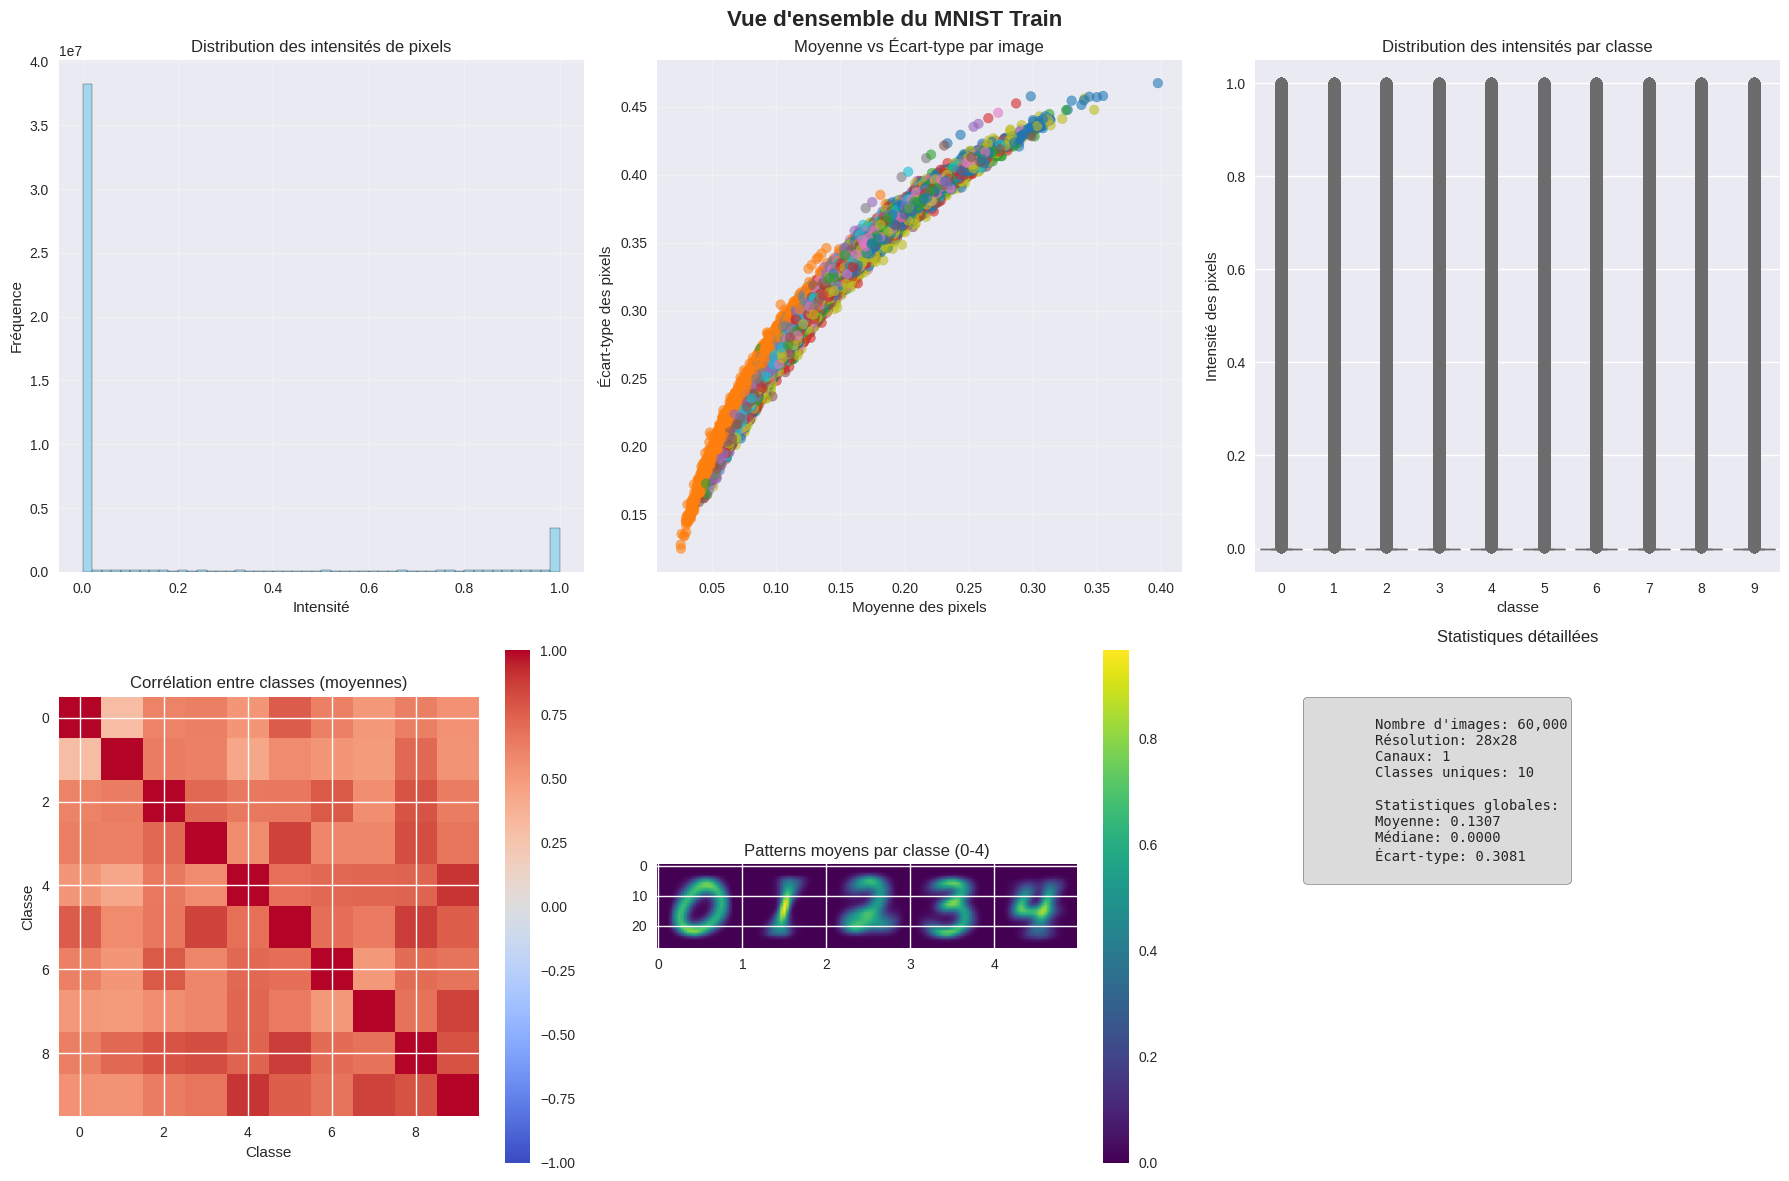

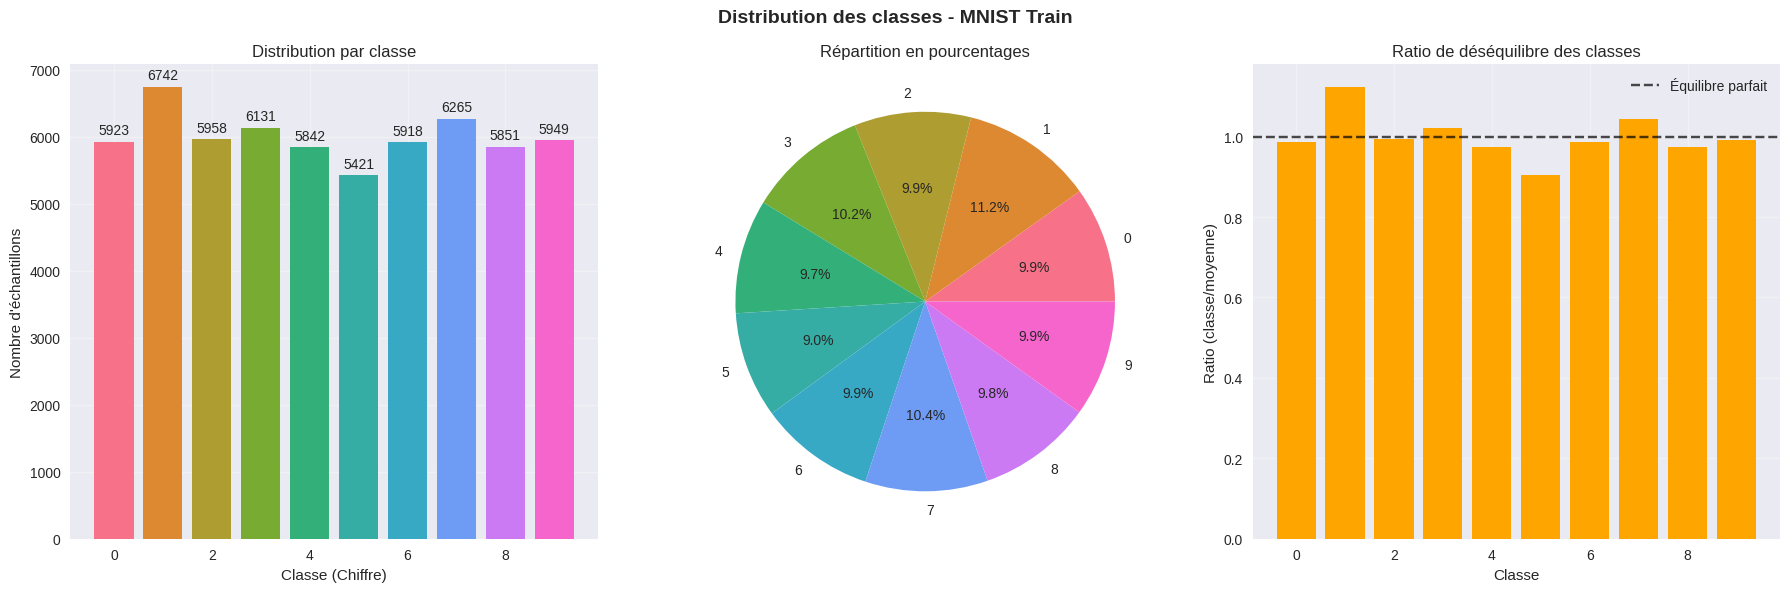

Classe majoritaire: 1 (6742 échantillons)
Classe minoritaire: 5 (5421 échantillons)
Ratio déséquilibre: 1.24:1


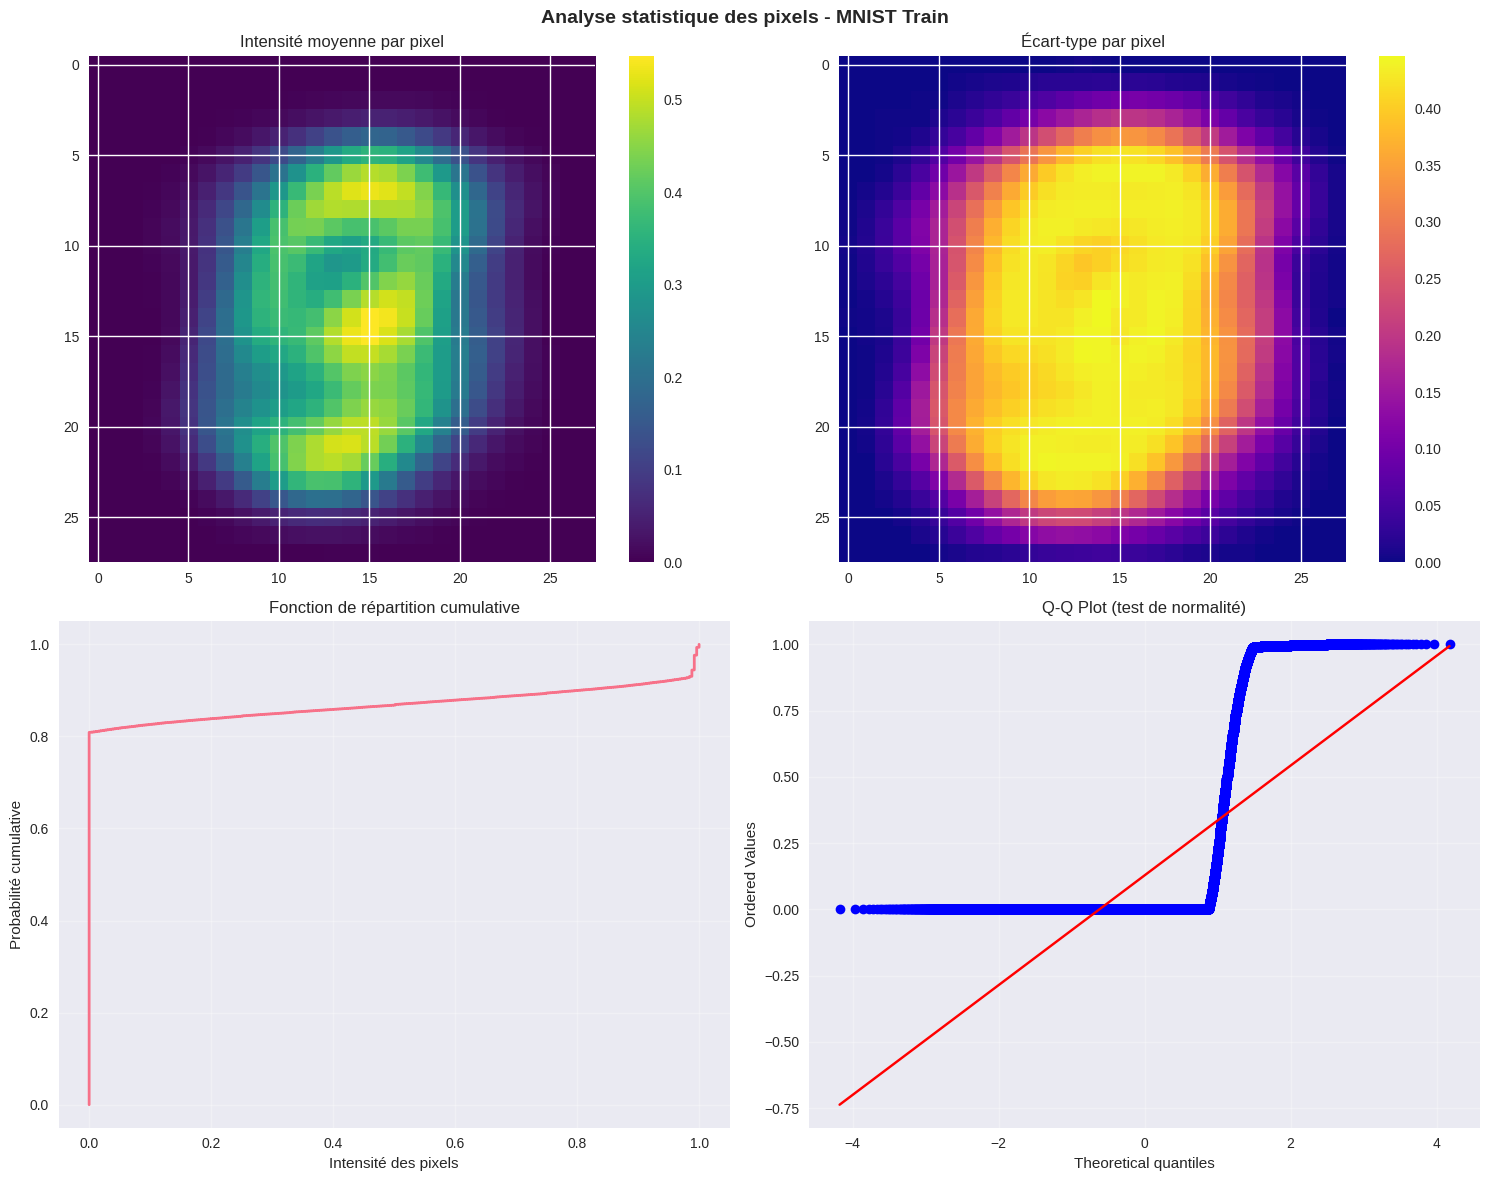

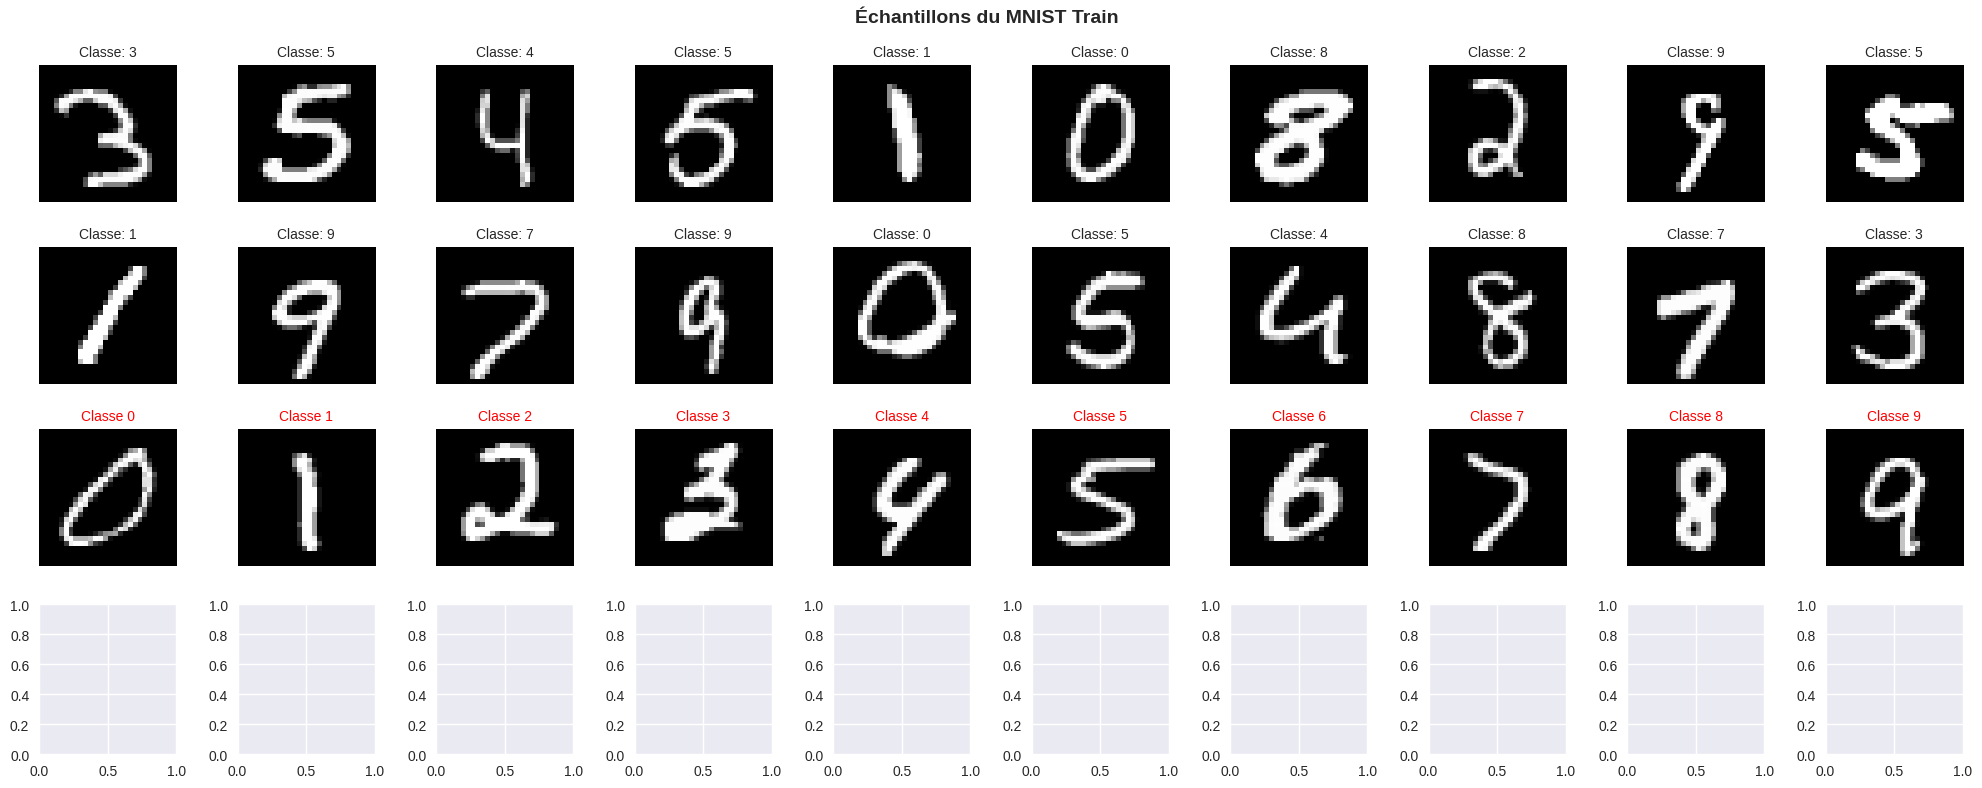

=== ANALYSE DU MNIST TEST ===
Forme des données: (10000, 28, 28, 1)
Forme des labels: (10000,)
Type des données: float32
Plage des valeurs: [0.000, 1.000]
Mémoire utilisée: 29.91 MB
Distribution des classes: {np.uint8(7): 1028, np.uint8(2): 1032, np.uint8(1): 1135, np.uint8(0): 980, np.uint8(4): 982, np.uint8(9): 1009, np.uint8(5): 892, np.uint8(6): 958, np.uint8(3): 1010, np.uint8(8): 974}


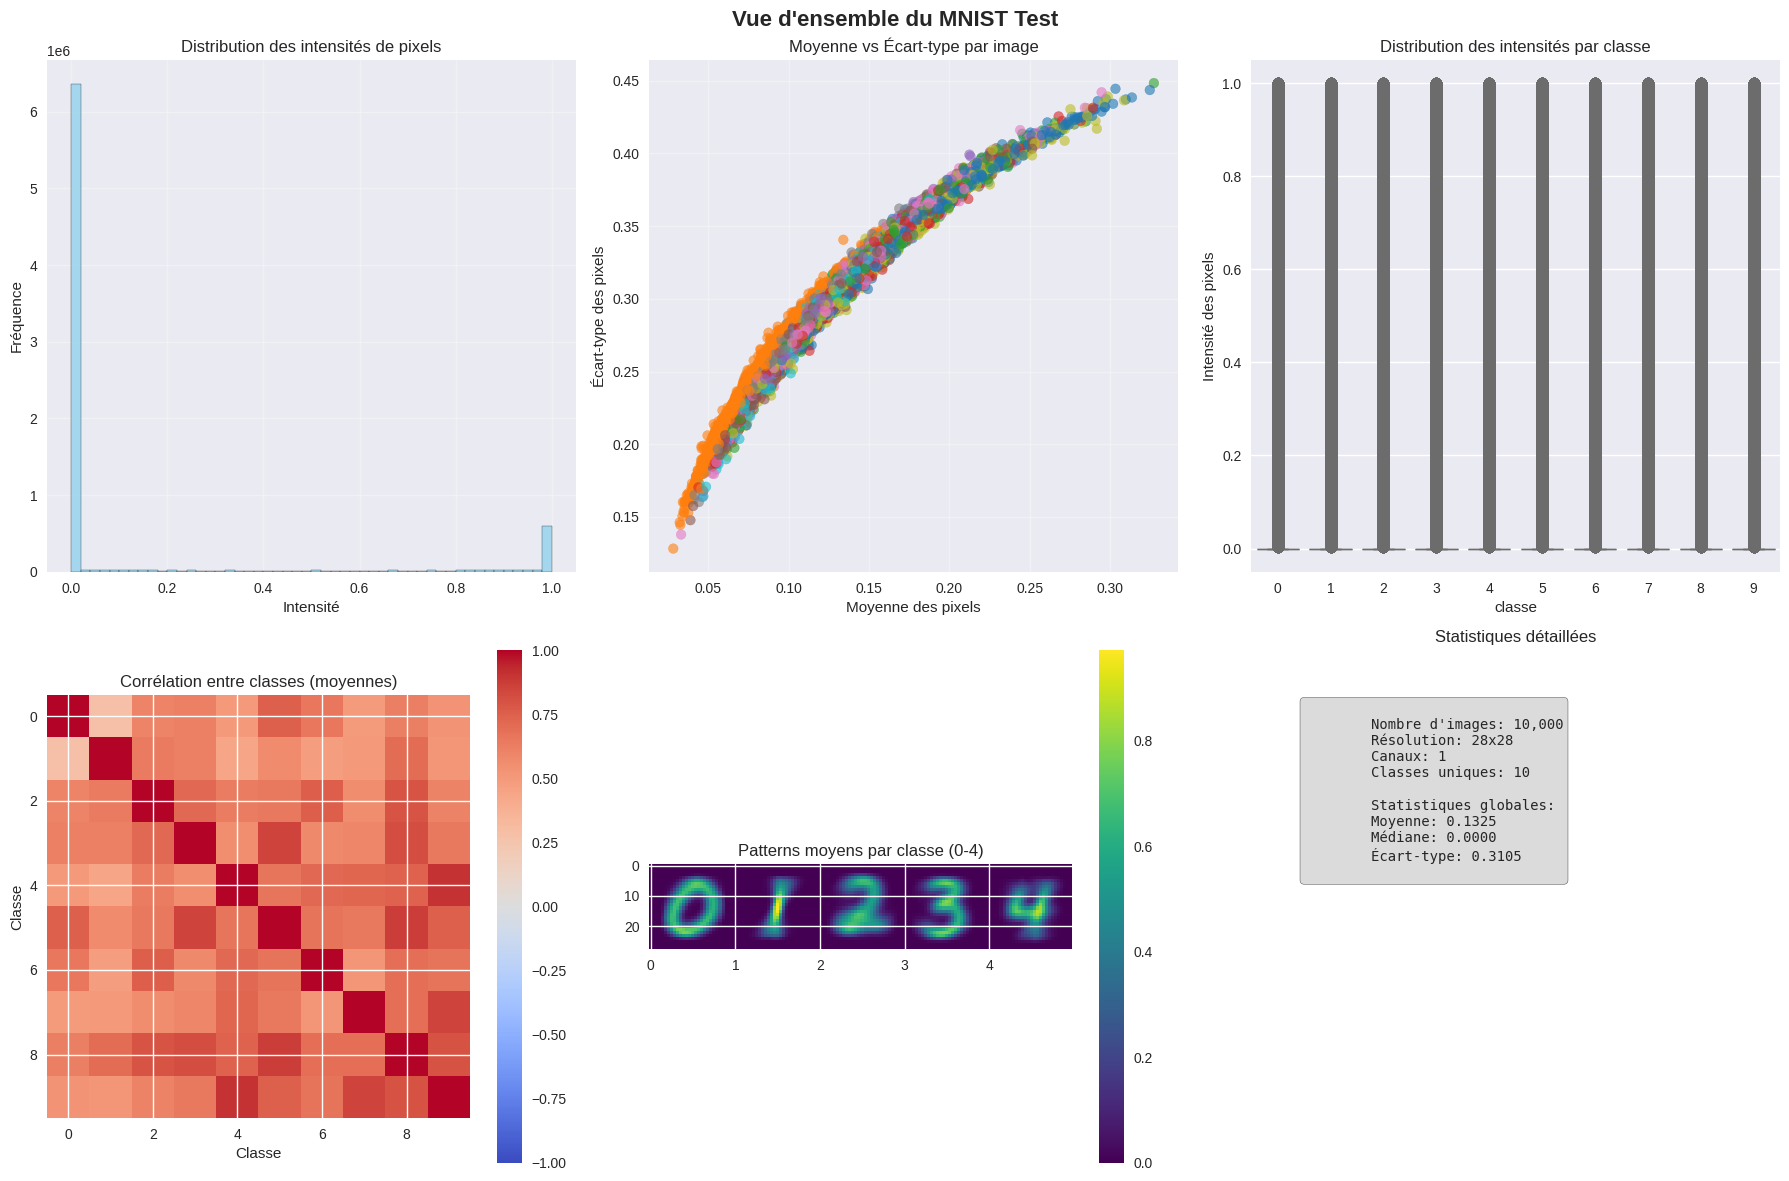

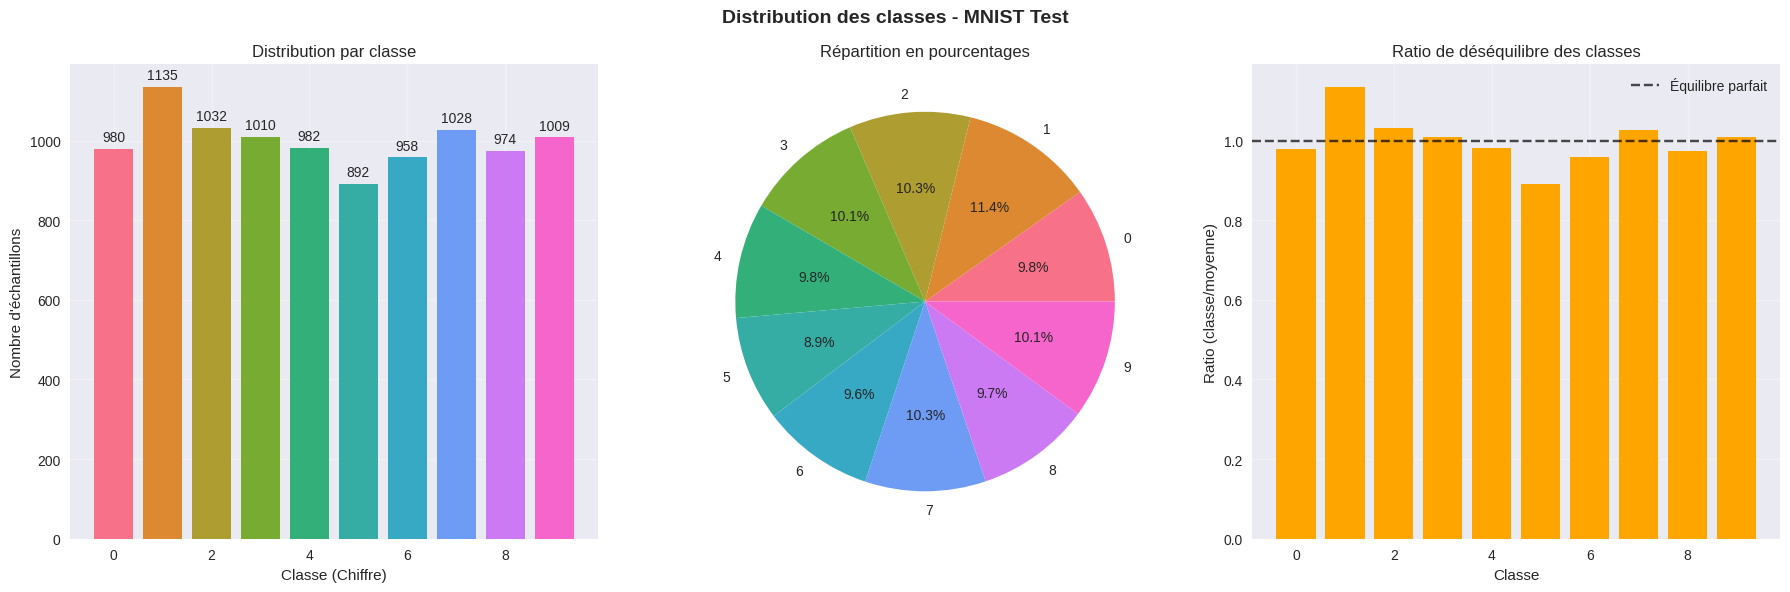

Classe majoritaire: 1 (1135 échantillons)
Classe minoritaire: 5 (892 échantillons)
Ratio déséquilibre: 1.27:1


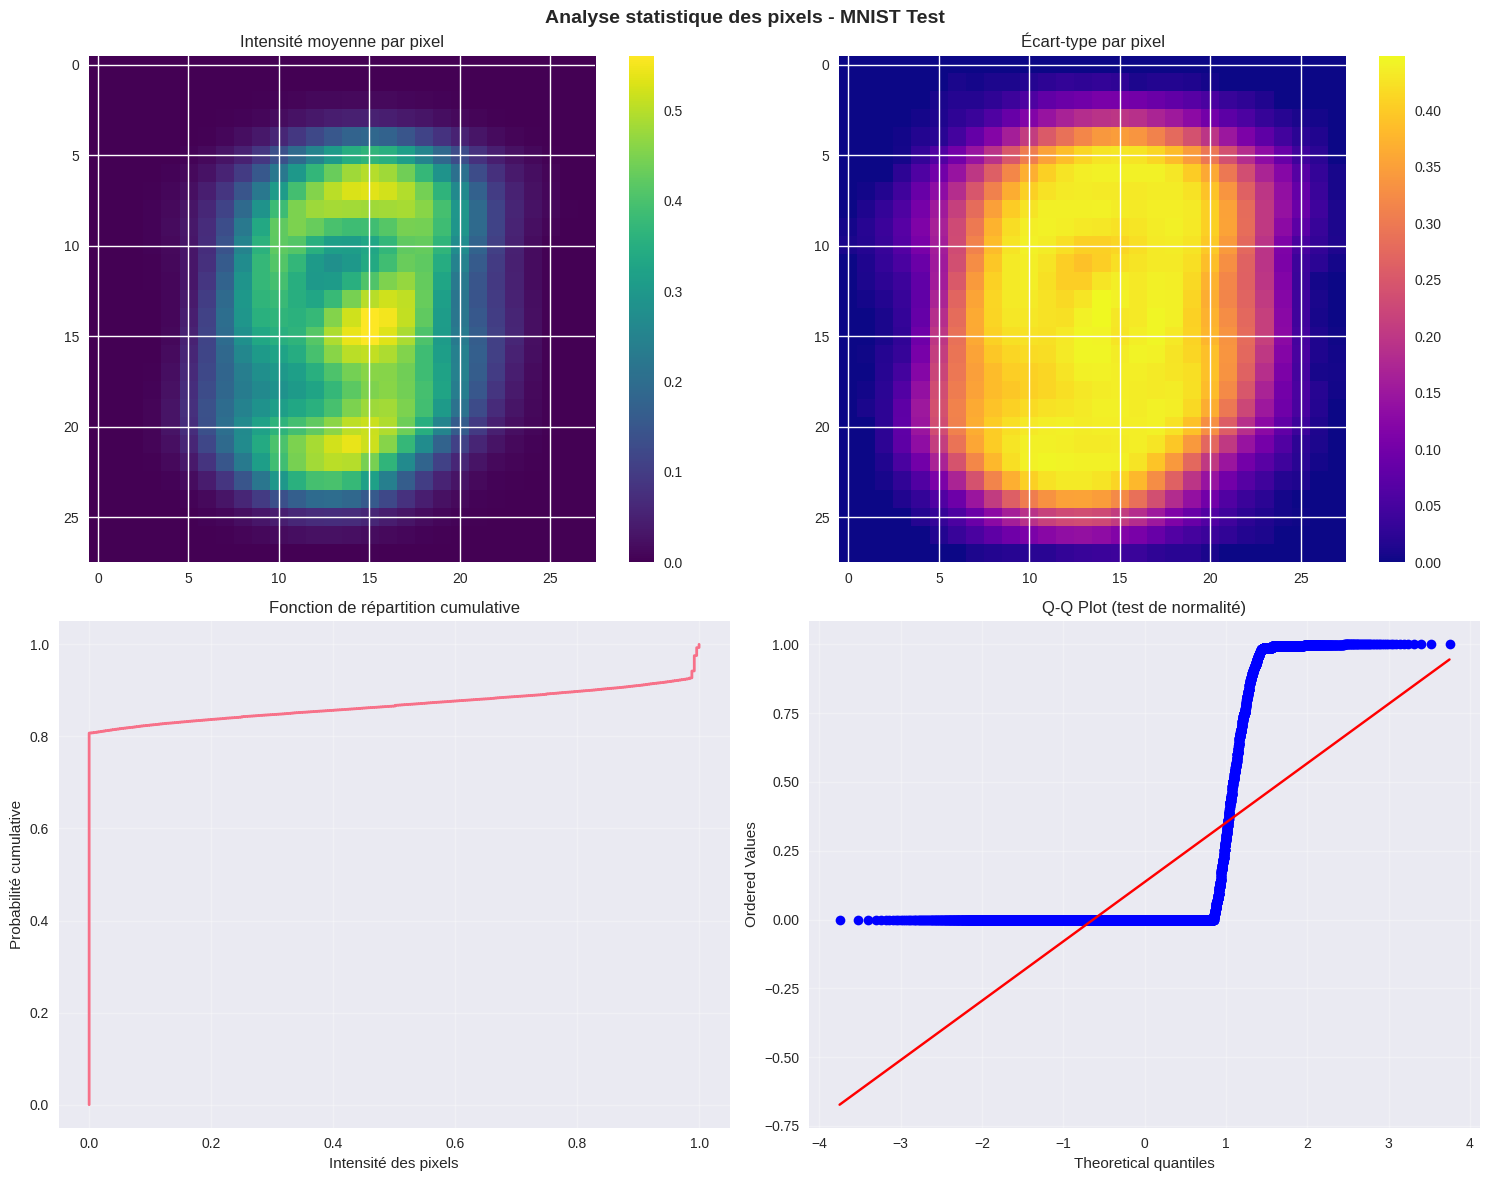

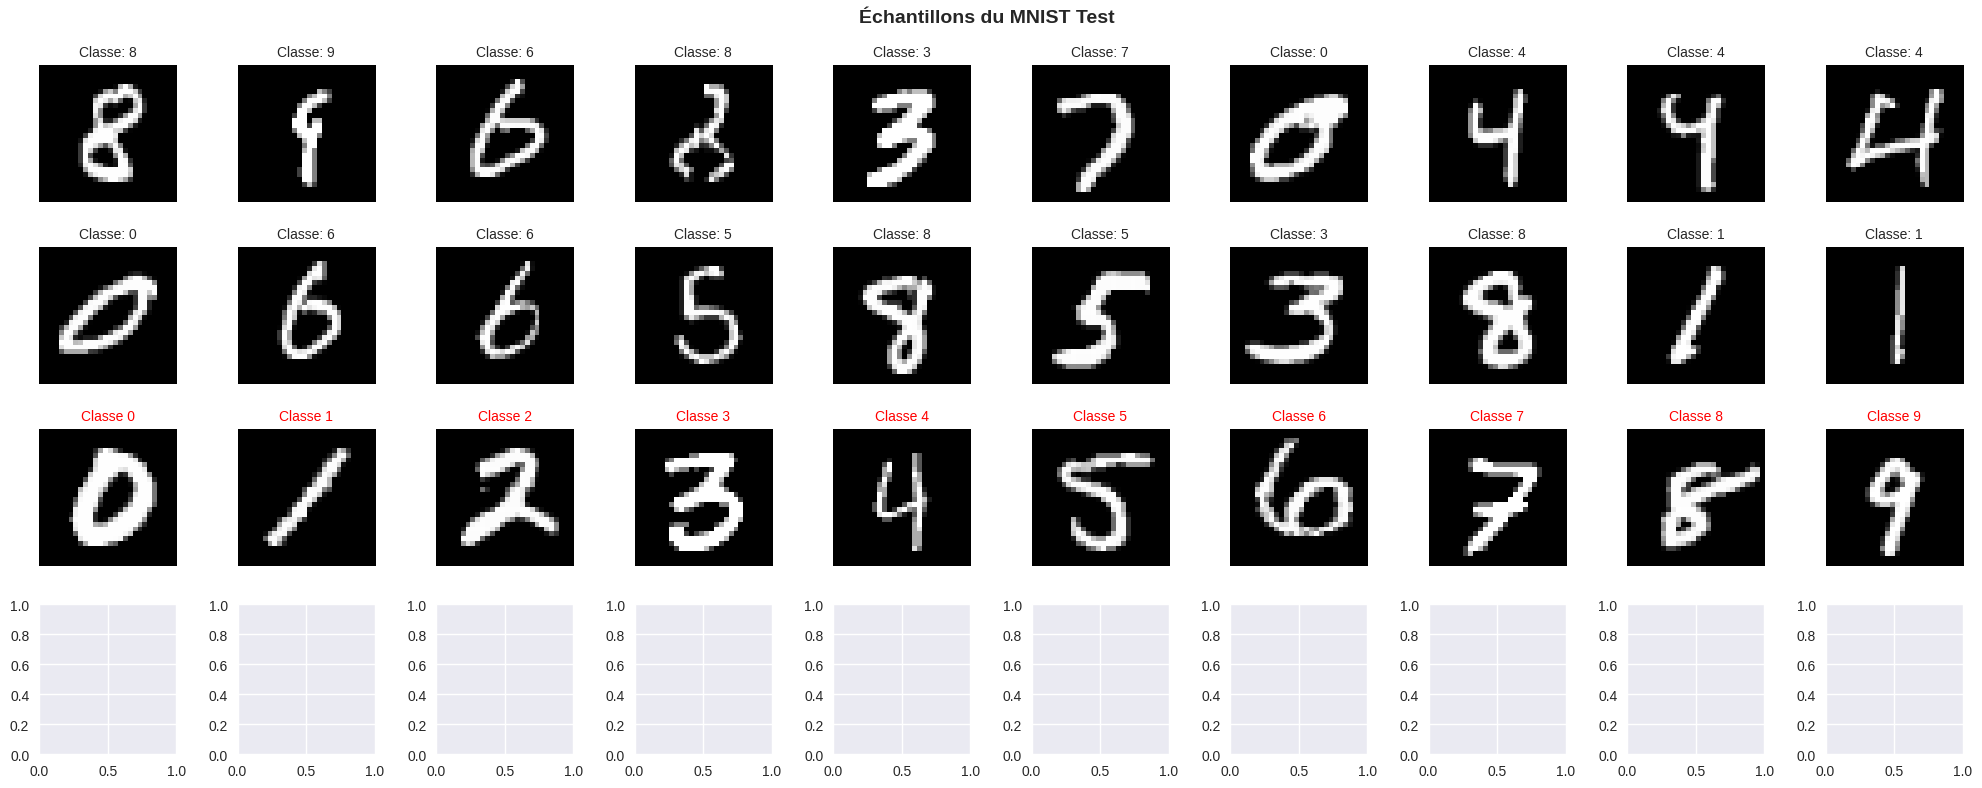


🔄 VISUALISATION DE L'AUGMENTATION DE DONNÉES...


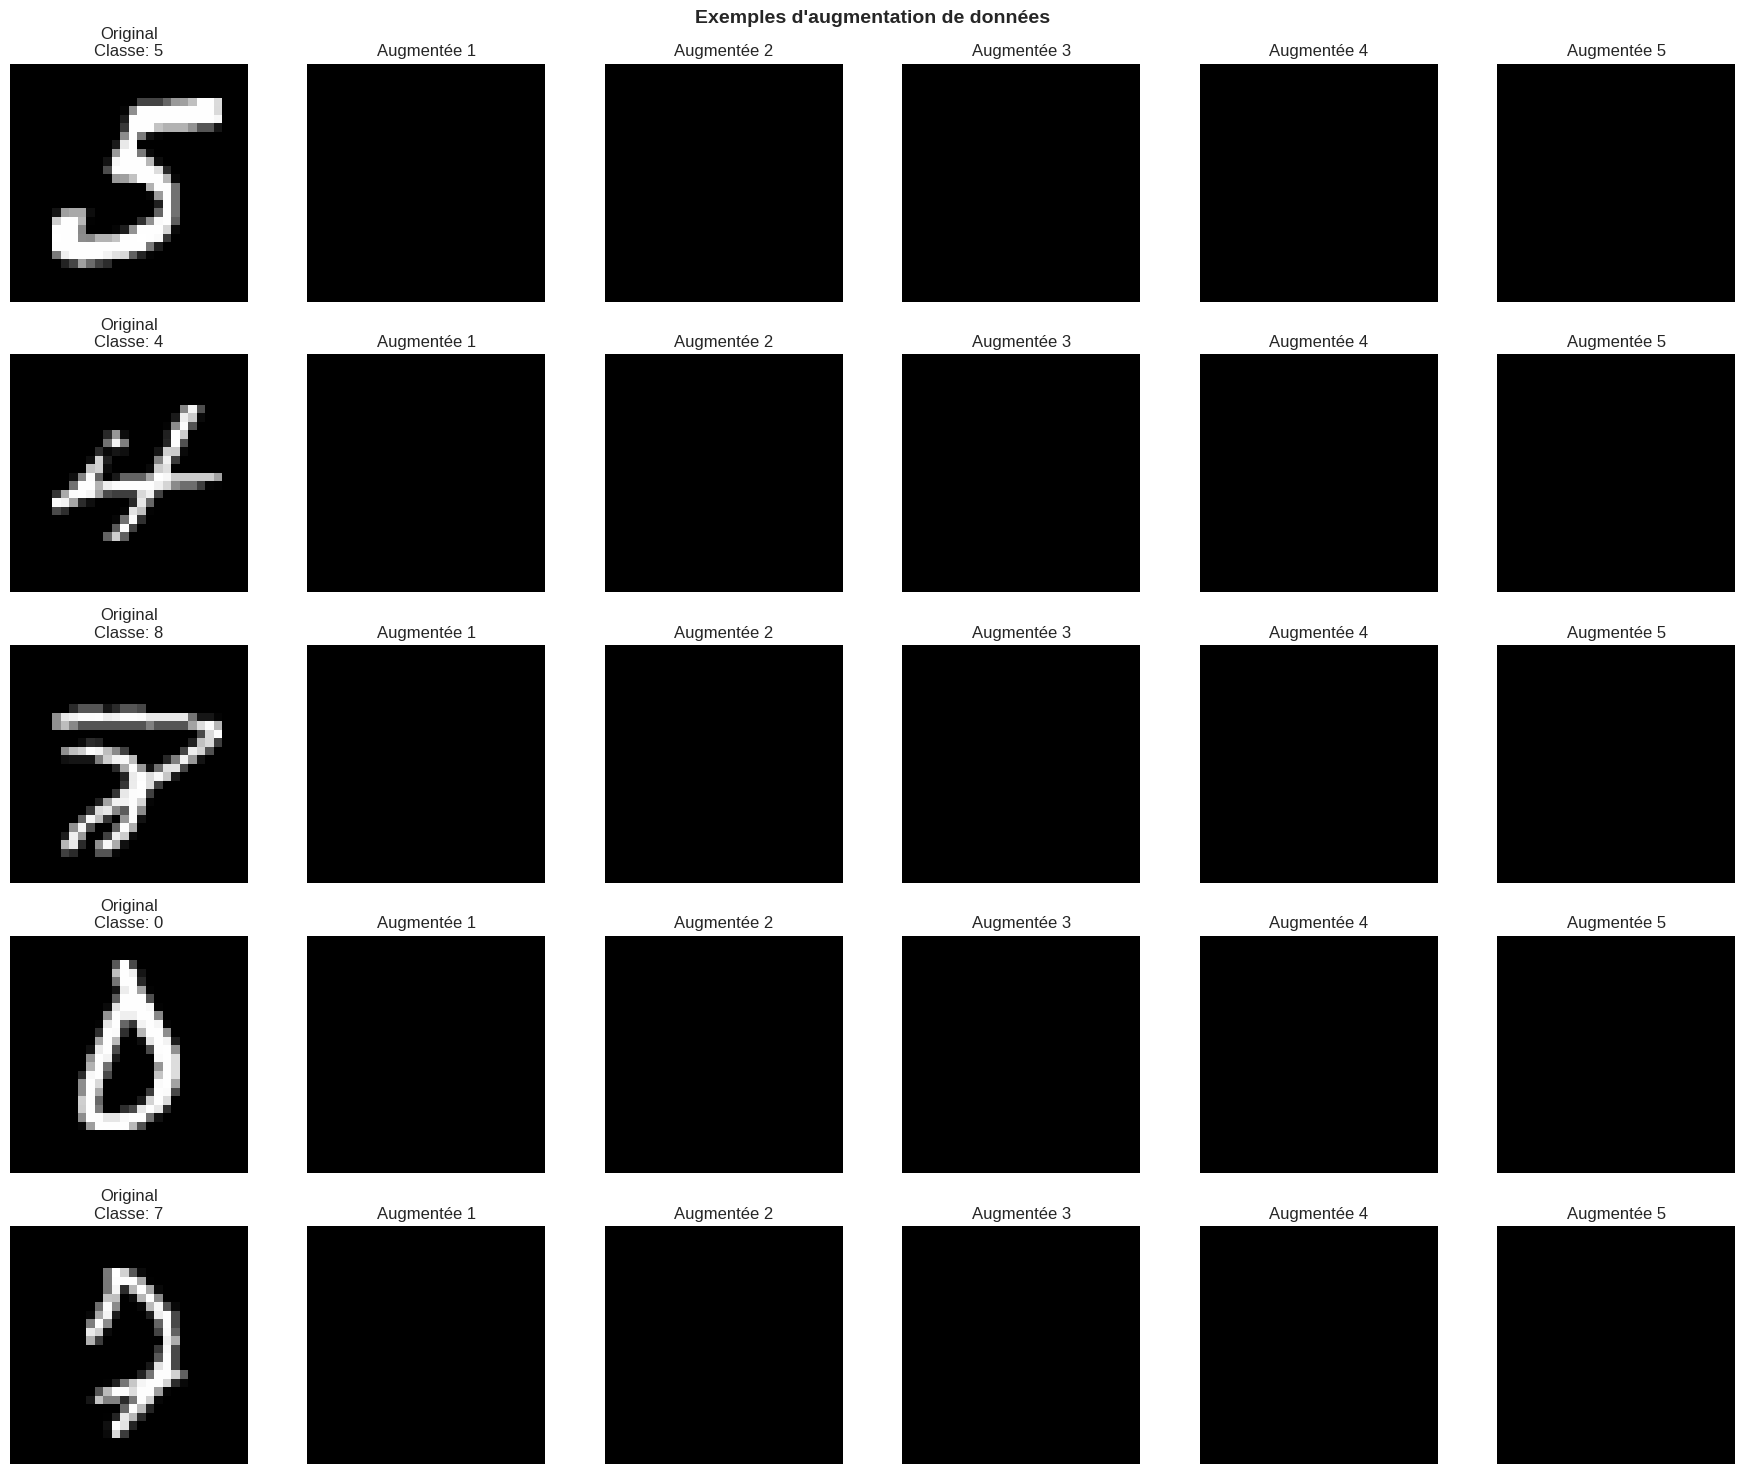


🏗️  CONSTRUCTION ET COMPARAISON DES MODÈLES...
Modèle CNN de base:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,370 (435.04 KB)

 Trainable params: 110,922 (433.29 KB)

 Non-trainable params: 448 (1.75 KB)


Modèle ResNet:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 14, 14,    │      3,200 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 7, 7, 64)  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 7, 7, 64)  │     36,928 │ max_pooling2d_5[… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 7, 7, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 7, 7, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 7, 7, 64)  │      4,160 │ max_pooling2d_5[… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 7, 7, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 7, 7, 64)  │        256 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 7, 7, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_add    │ (None, 7, 7, 64)  │          0 │ conv2_block1_0_b… │
│ (Add)               │                   │            │ conv2_block1_2_b… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 7, 7, 64)  │          0 │ conv2_block1_add… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 7, 7, 64)  │     36,928 │ conv2_block1_out… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_bn   │ (None, 7, 7, 64)  │        256 │ conv2_block2_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_relu │ (None, 7, 7, 64)  │          0 │ conv2_block2_1_b

 Total params: 685,386 (2.61 MB)

 Trainable params: 683,338 (2.61 MB)

 Non-trainable params: 2,048 (8.00 KB)


🎯 ENTRAÎNEMENT DU MODÈLE RESNET...
Epoch 1/30
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.0999 - loss: 2.4916
Epoch 1: val_accuracy improved from -inf to 0.19500, saving model to best_digit_model.h5


937/937 ━━━━━━━━━━━━━━━━━━━━ 76s 65ms/step - accuracy: 0.0999 - loss: 2.4915 - val_accuracy: 0.1950 - val_loss: 2.7533 - learning_rate: 0.0010
Epoch 2/30
  1/937 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.0469 - loss: 2.3794
Epoch 2: val_accuracy improved from 0.19500 to 0.20640, saving model to best_digit_model.h5


937/937 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0469 - loss: 2.3794 - val_accuracy: 0.2064 - val_loss: 2.7772 - learning_rate: 0.0010
Epoch 3/30
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.1071 - loss: 2.3117
Epoch 3: val_accuracy improved from 0.20640 to 0.38590, saving model to best_digit_model.h5


937/937 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.1071 - loss: 2.3117 - val_accuracy: 0.3859 - val_loss: 1.9243 - learning_rate: 0.0010
Epoch 4/30
  1/937 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.1250 - loss: 2.2781
Epoch 4: val_accuracy did not improve from 0.38590
937/937 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1250 - loss: 2.2781 - val_accuracy: 0.3746 - val_loss: 1.9764 - learning_rate: 0.0010
Epoch 5/30
936/937 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1063 - loss: 2.3048
Epoch 5: val_accuracy improved from 0.38590 to 0.42090, saving model to best_digit_model.h5


937/937 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.1063 - loss: 2.3047 - val_accuracy: 0.4209 - val_loss: 1.4828 - learning_rate: 0.0010
Epoch 6/30
  1/937 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.0469 - loss: 2.3280
Epoch 6: val_accuracy did not improve from 0.42090
937/937 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0469 - loss: 2.3280 - val_accuracy: 0.4186 - val_loss: 1.4802 - learning_rate: 0.0010
Epoch 7/30
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1111 - loss: 2.2997
Epoch 7: val_accuracy improved from 0.42090 to 0.65040, saving model to best_digit_model.h5


937/937 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.1111 - loss: 2.2997 - val_accuracy: 0.6504 - val_loss: 1.1259 - learning_rate: 0.0010
Epoch 8/30
  1/937 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.1719 - loss: 2.3104
Epoch 8: val_accuracy did not improve from 0.65040
937/937 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1719 - loss: 2.3104 - val_accuracy: 0.6471 - val_loss: 1.1276 - learning_rate: 0.0010
Epoch 9/30
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1119 - loss: 2.2959
Epoch 9: val_accuracy improved from 0.65040 to 0.79440, saving model to best_digit_model.h5


937/937 ━━━━━━━━━━━━━━━━━━━━ 46s 49ms/step - accuracy: 0.1119 - loss: 2.2959 - val_accuracy: 0.7944 - val_loss: 0.6639 - learning_rate: 0.0010
Epoch 10/30
  1/937 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.1250 - loss: 2.2982
Epoch 10: val_accuracy improved from 0.79440 to 0.79550, saving model to best_digit_model.h5


937/937 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1250 - loss: 2.2982 - val_accuracy: 0.7955 - val_loss: 0.6611 - learning_rate: 0.0010
Epoch 11/30
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1143 - loss: 2.2937
Epoch 11: val_accuracy did not improve from 0.79550
937/937 ━━━━━━━━━━━━━━━━━━━━ 80s 49ms/step - accuracy: 0.1143 - loss: 2.2937 - val_accuracy: 0.5830 - val_loss: 1.4408 - learning_rate: 0.0010
Epoch 12/30
  1/937 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.1094 - loss: 2.3158
Epoch 12: val_accuracy did not improve from 0.79550
937/937 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1094 - loss: 2.3158 - val_accuracy: 0.5860 - val_loss: 1.4303 - learning_rate: 0.0010
Epoch 13/30
936/937 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1179 - loss: 2.2883
Epoch 13: val_accuracy improved from 0.79550 to 0.84370, saving model to best_digit_model.h5


937/937 ━━━━━━━━━━━━━━━━━━━━ 47s 50ms/step - accuracy: 0.1179 - loss: 2.2883 - val_accuracy: 0.8437 - val_loss: 0.4971 - learning_rate: 0.0010
Epoch 14/30
  1/937 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.1094 - loss: 2.2831
Epoch 14: val_accuracy improved from 0.84370 to 0.84980, saving model to best_digit_model.h5


937/937 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1094 - loss: 2.2831 - val_accuracy: 0.8498 - val_loss: 0.4863 - learning_rate: 0.0010
Epoch 15/30
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1190 - loss: 2.2886
Epoch 15: val_accuracy did not improve from 0.84980
937/937 ━━━━━━━━━━━━━━━━━━━━ 79s 48ms/step - accuracy: 0.1190 - loss: 2.2886 - val_accuracy: 0.7707 - val_loss: 0.6612 - learning_rate: 0.0010
Epoch 16/30
  1/937 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.1250 - loss: 2.3017
Epoch 16: val_accuracy did not improve from 0.84980
937/937 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1250 - loss: 2.3017 - val_accuracy: 0.7737 - val_loss: 0.6585 - learning_rate: 0.0010
Epoch 17/30
936/937 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1177 - loss: 2.2877
Epoch 17: val_accuracy did not improve from 0.84980
937/937 ━━━━━━━━━━━━━━━━━━━━ 82s 50ms/step - accuracy: 0.1176 - loss: 2.2877 - val_accuracy: 0.6847 - val_loss: 1.0135 - learning_rate: 0.0010
Epoch 18/30

937/937 ━━━━━━━━━━━━━━━━━━━━ 82s 49ms/step - accuracy: 0.1176 - loss: 2.2876 - val_accuracy: 0.8787 - val_loss: 0.3587 - learning_rate: 5.0000e-04
Epoch 22/30
  1/937 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.1250 - loss: 2.2964
Epoch 22: val_accuracy did not improve from 0.87870
937/937 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1250 - loss: 2.2964 - val_accuracy: 0.8774 - val_loss: 0.3634 - learning_rate: 5.0000e-04
Epoch 23/30
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1200 - loss: 2.2823
Epoch 23: val_accuracy did not improve from 0.87870
937/937 ━━━━━━━━━━━━━━━━━━━━ 46s 49ms/step - accuracy: 0.1200 - loss: 2.2823 - val_accuracy: 0.8550 - val_loss: 0.4640 - learning_rate: 5.0000e-04
Epoch 24/30
  1/937 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.1406 - loss: 2.2672
Epoch 24: val_accuracy did not improve from 0.87870
937/937 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1406 - loss: 2.2672 - val_accuracy: 0.8566 - val_loss: 0.4576 - learning_rate: 5.0000

937/937 ━━━━━━━━━━━━━━━━━━━━ 45s 48ms/step - accuracy: 0.1219 - loss: 2.2826 - val_accuracy: 0.8930 - val_loss: 0.3129 - learning_rate: 2.5000e-04
Epoch 28/30
  1/937 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.0625 - loss: 2.3076
Epoch 28: val_accuracy did not improve from 0.89300
937/937 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0625 - loss: 2.3076 - val_accuracy: 0.8926 - val_loss: 0.3142 - learning_rate: 2.5000e-04
Epoch 29/30
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1182 - loss: 2.2843
Epoch 29: val_accuracy improved from 0.89300 to 0.90300, saving model to best_digit_model.h5


937/937 ━━━━━━━━━━━━━━━━━━━━ 80s 47ms/step - accuracy: 0.1182 - loss: 2.2843 - val_accuracy: 0.9030 - val_loss: 0.2925 - learning_rate: 2.5000e-04
Epoch 30/30
  1/937 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.1094 - loss: 2.3029
Epoch 30: val_accuracy improved from 0.90300 to 0.90320, saving model to best_digit_model.h5


937/937 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1094 - loss: 2.3029 - val_accuracy: 0.9032 - val_loss: 0.2925 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 30.

📈 ANALYSE DE L'ENTRAÎNEMENT...


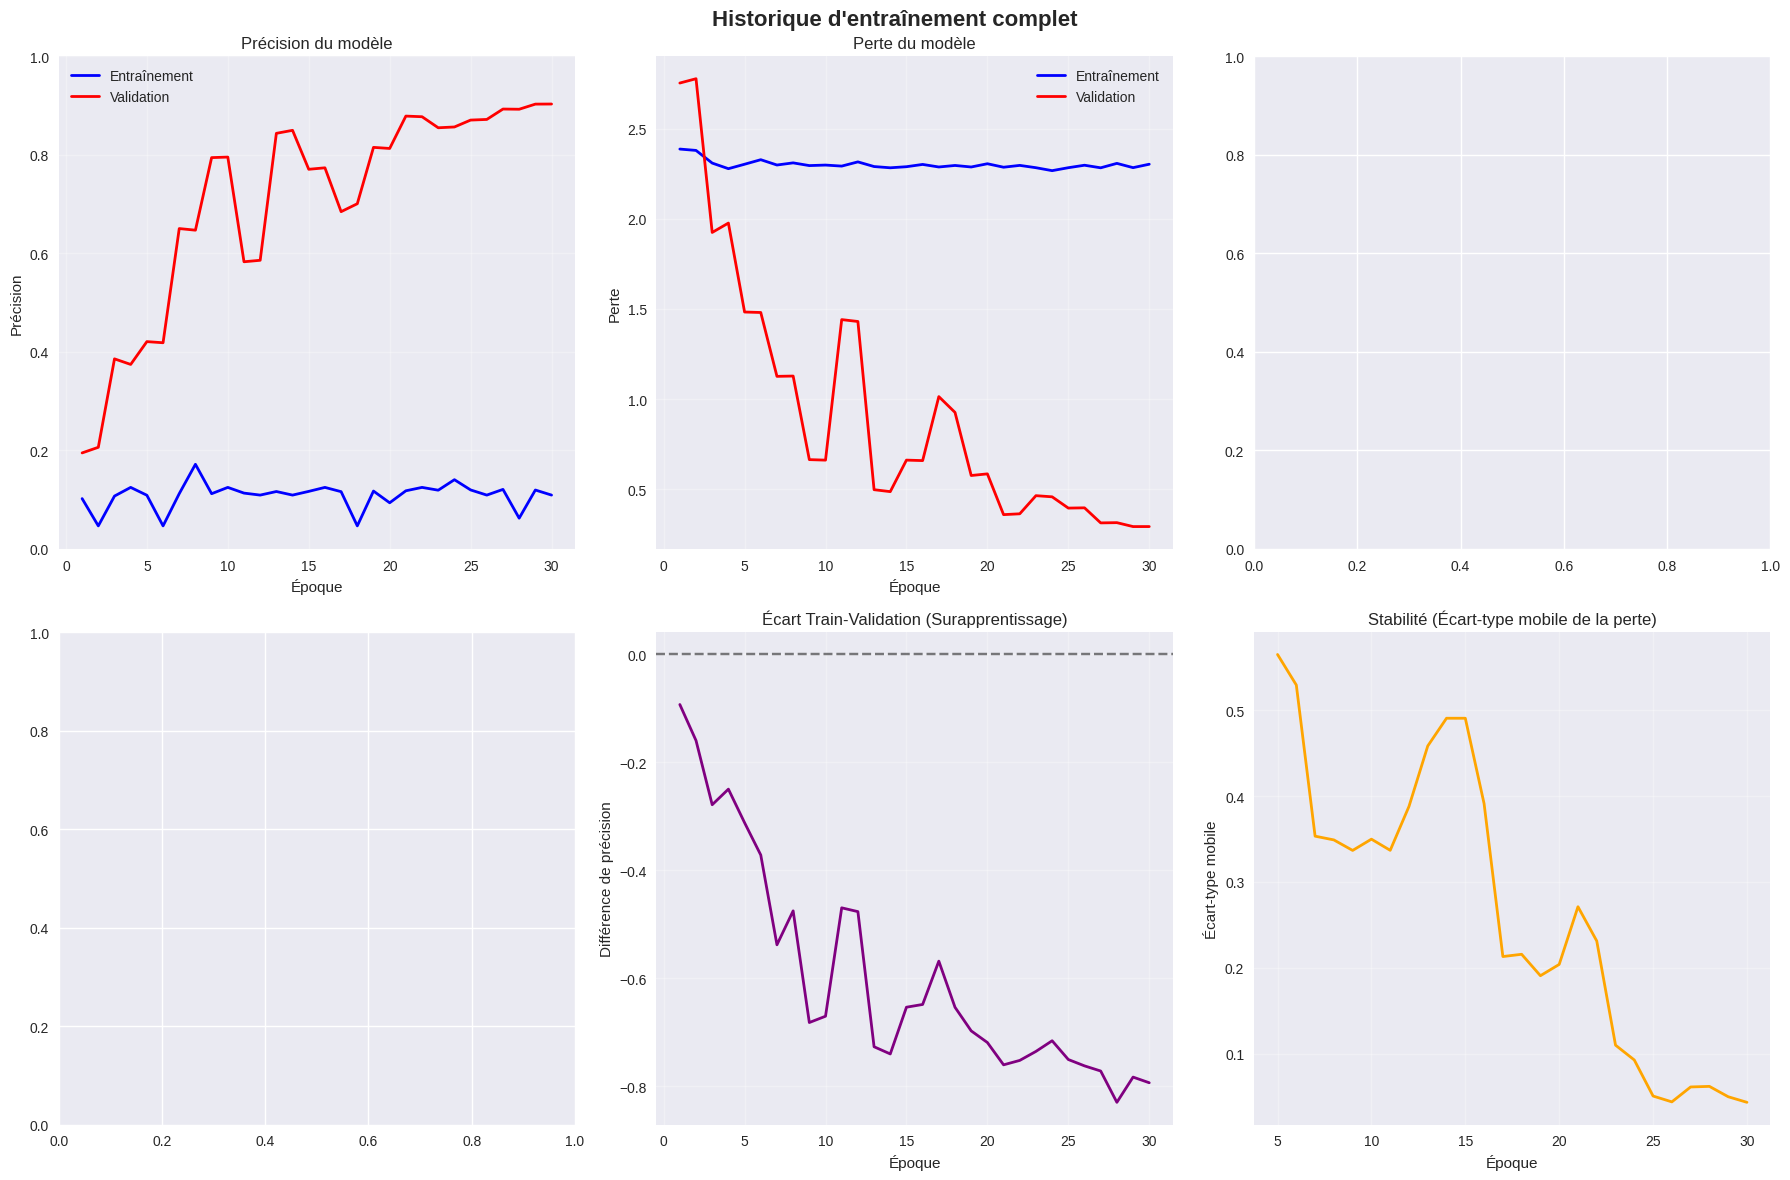


=== STATISTIQUES FINALES (Époque 30) ===
Précision d'entraînement: 0.1094
Précision de validation: 0.9032
Perte d'entraînement: 2.3029
Perte de validation: 0.2925
✅ Bon équilibre train/validation

🎯 ÉVALUATION COMPLÈTE DU MODÈLE...
=== ÉVALUATION COMPLÈTE - MNIST TEST ===
Perte: 0.2925
Précision: 0.9032

Rapport de classification:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       980
           1       0.98      0.98      0.98      1135
           2       0.98      0.89      0.93      1032
           3       0.99      0.83      0.90      1010
           4       0.99      0.75      0.85       982
           5       0.81      0.94      0.87       892
           6       0.98      0.90      0.94       958
           7       0.91      0.96      0.94      1028
           8       0.81      0.90      0.86       974
           9       0.75      0.89      0.82      1009

    accuracy                           0.90     10000
   macro avg    

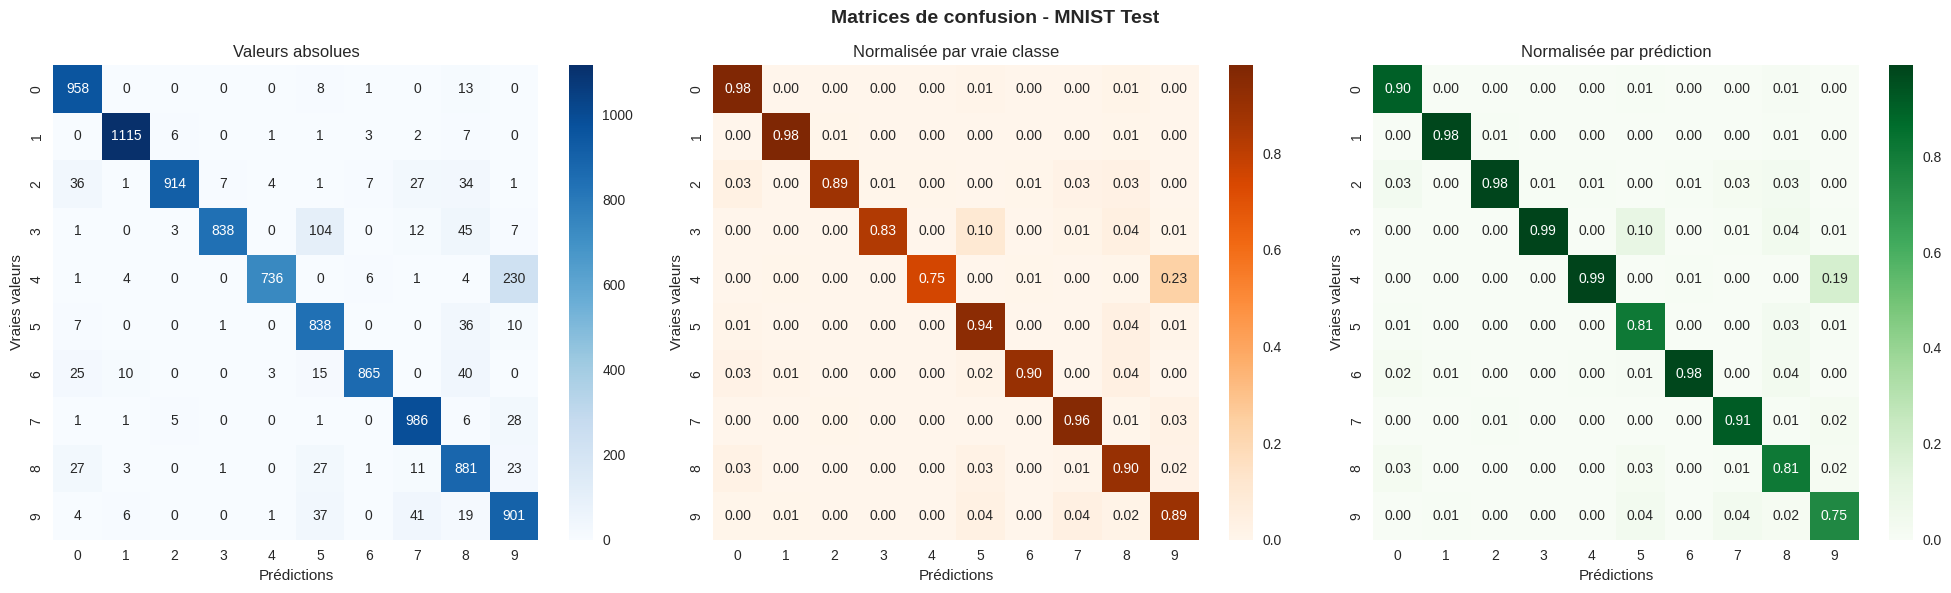

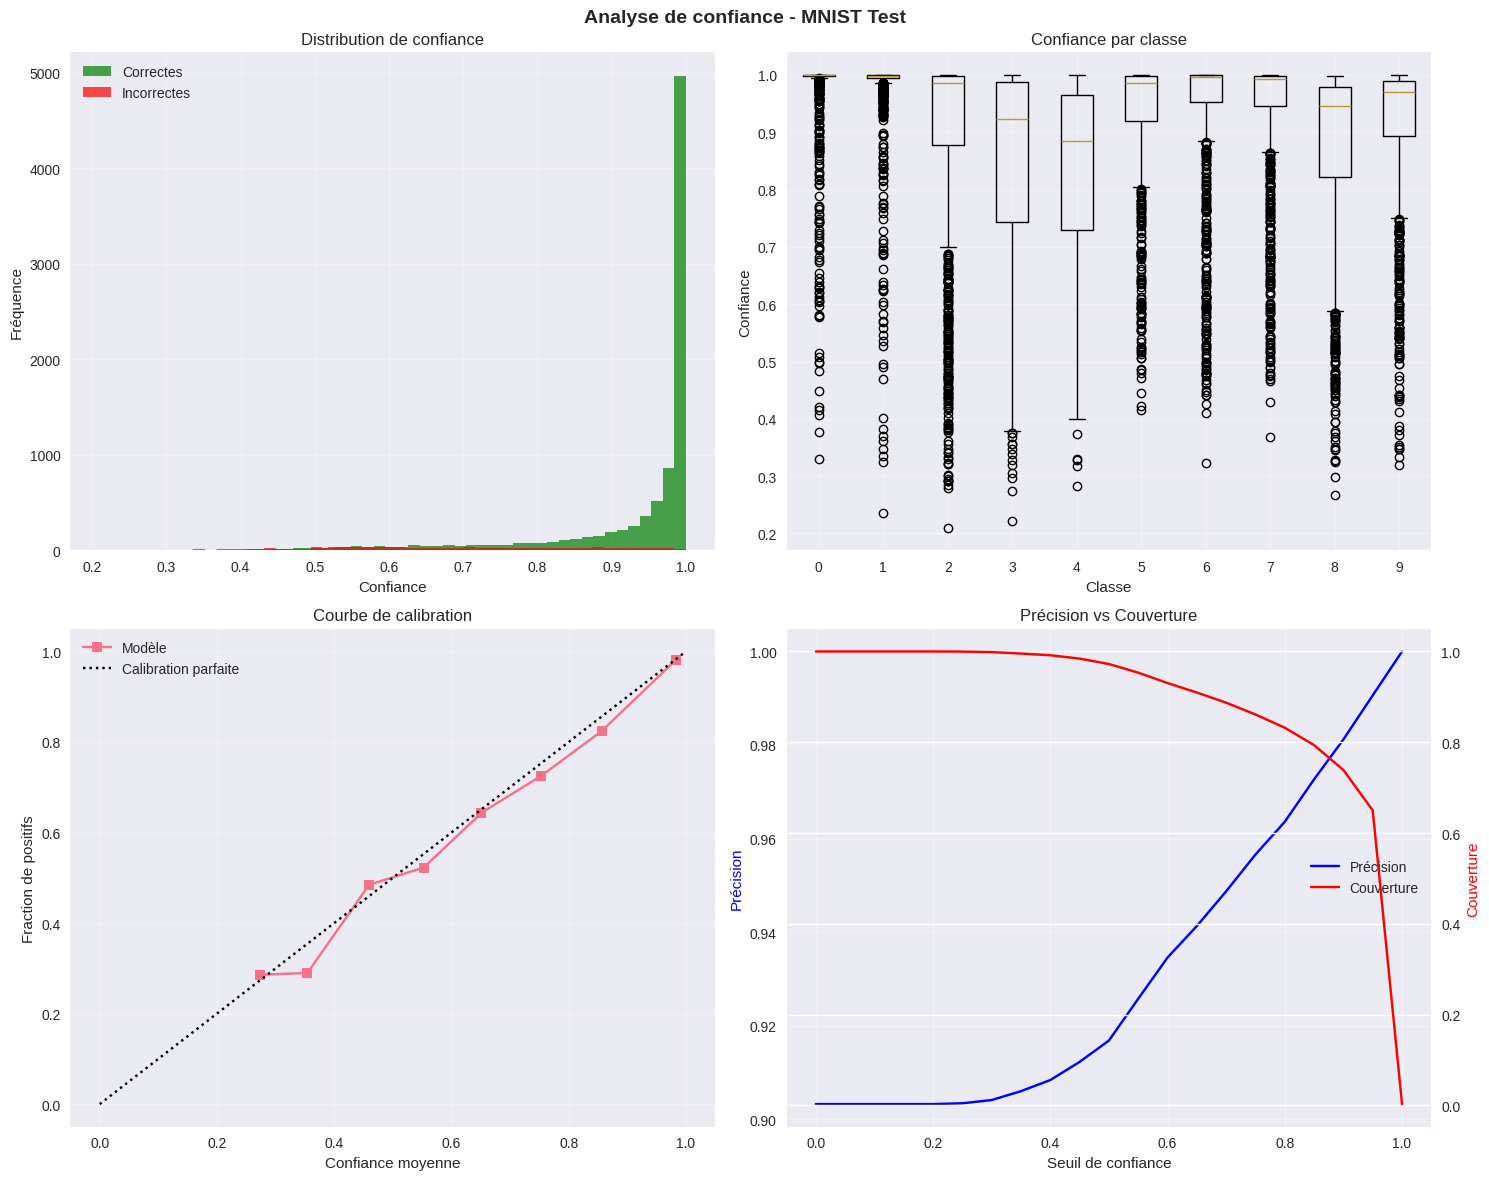

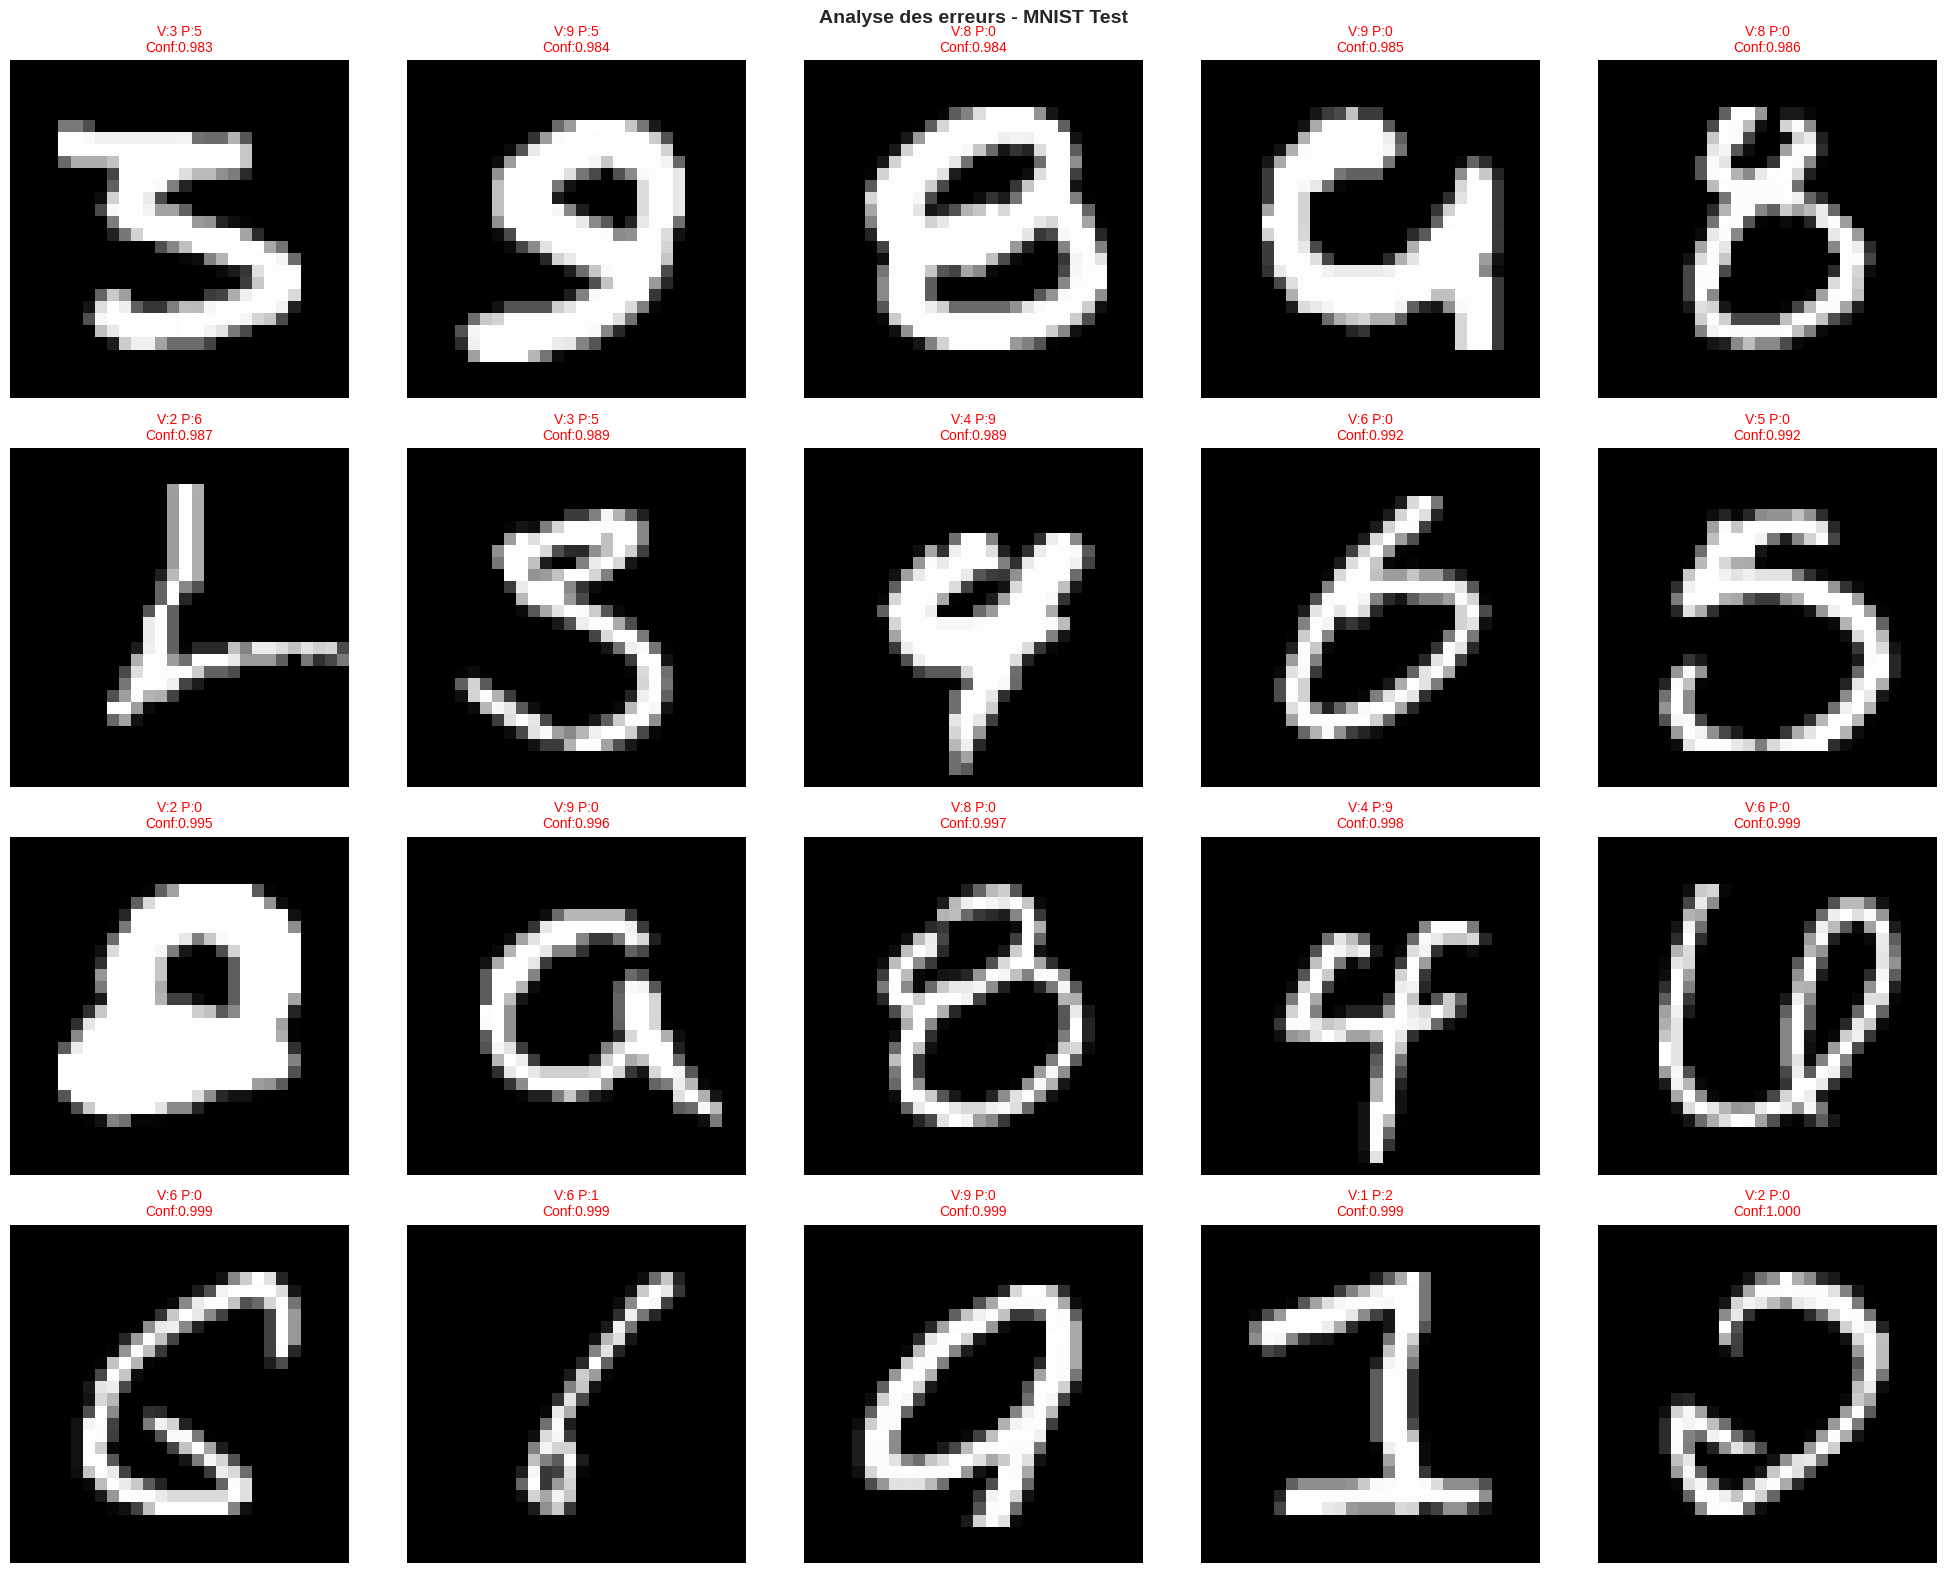

Nombre total d'erreurs: 968 (9.68%)

Taux d'erreur par classe:
  Classe 4: 0.251
  Classe 3: 0.170
  Classe 2: 0.114
  Classe 9: 0.107
  Classe 6: 0.097
  Classe 8: 0.095
  Classe 5: 0.061
  Classe 7: 0.041
  Classe 0: 0.022
  Classe 1: 0.018


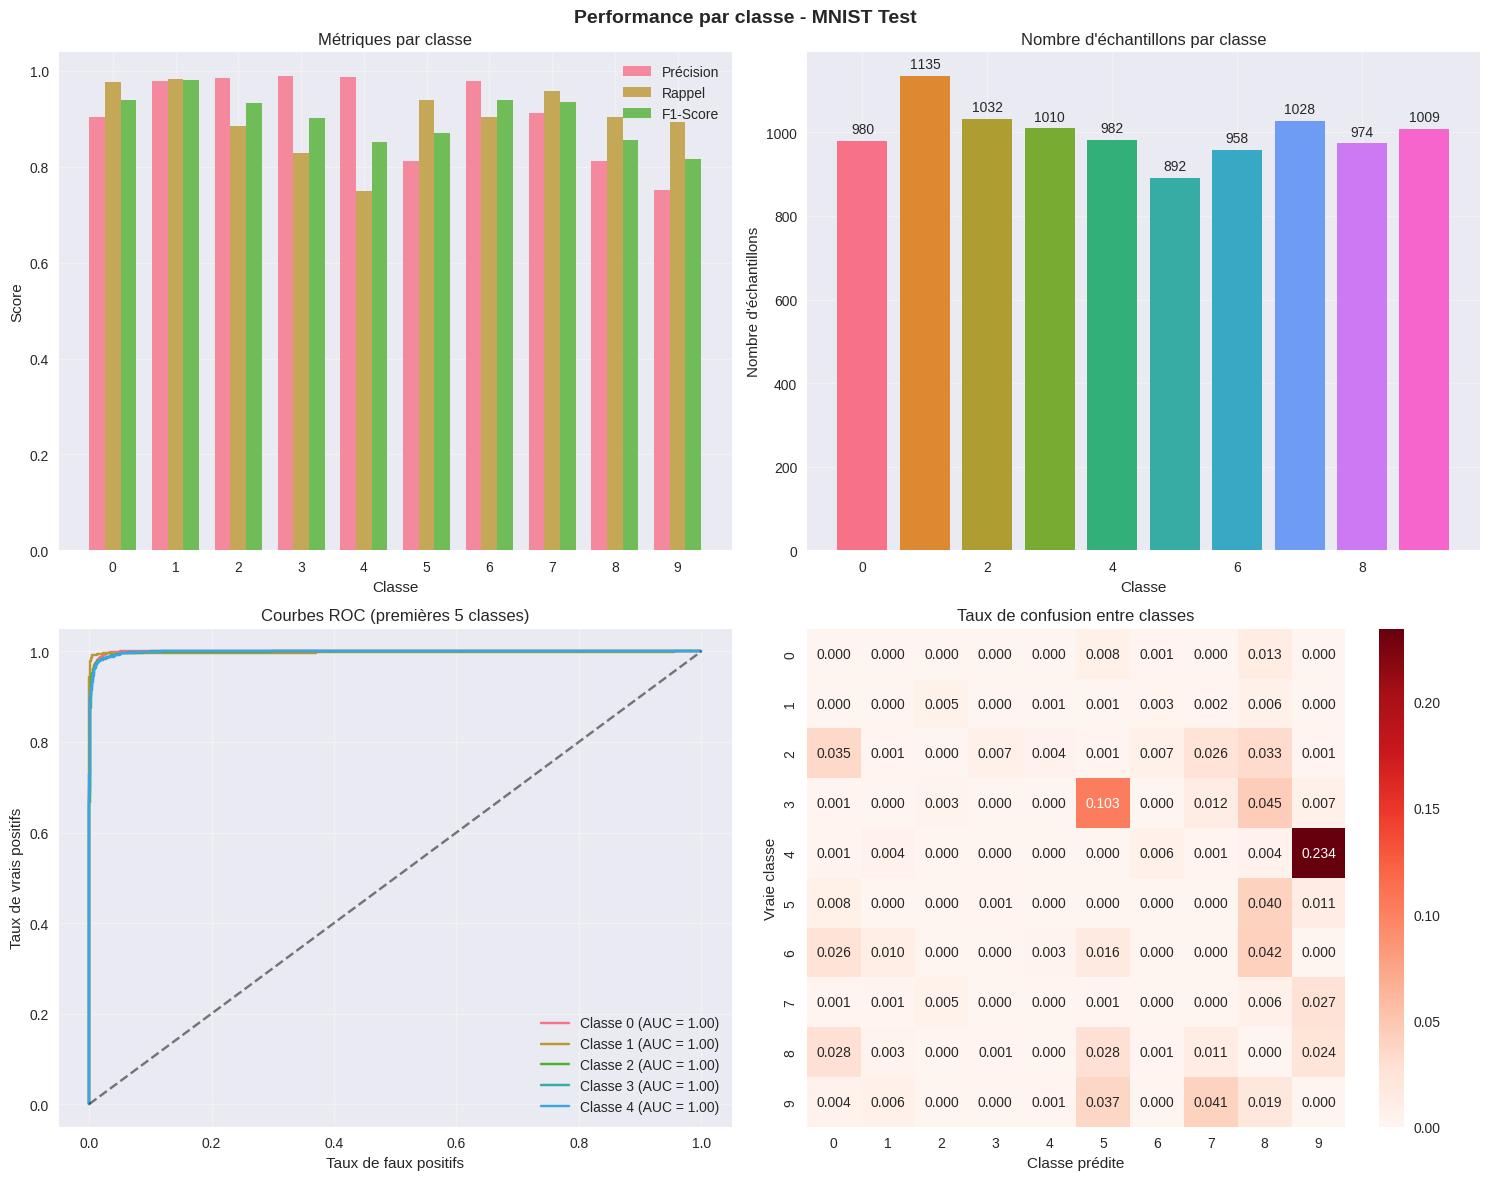


💾 Modèle sauvegardé: final_digit_recognition_model.h5

🖼️  TEST AVEC IMAGES PERSONNALISÉES
Téléversez vos images de chiffres...


Saving 5.png to 5 (1).png

Analyse de 5 (1).png:


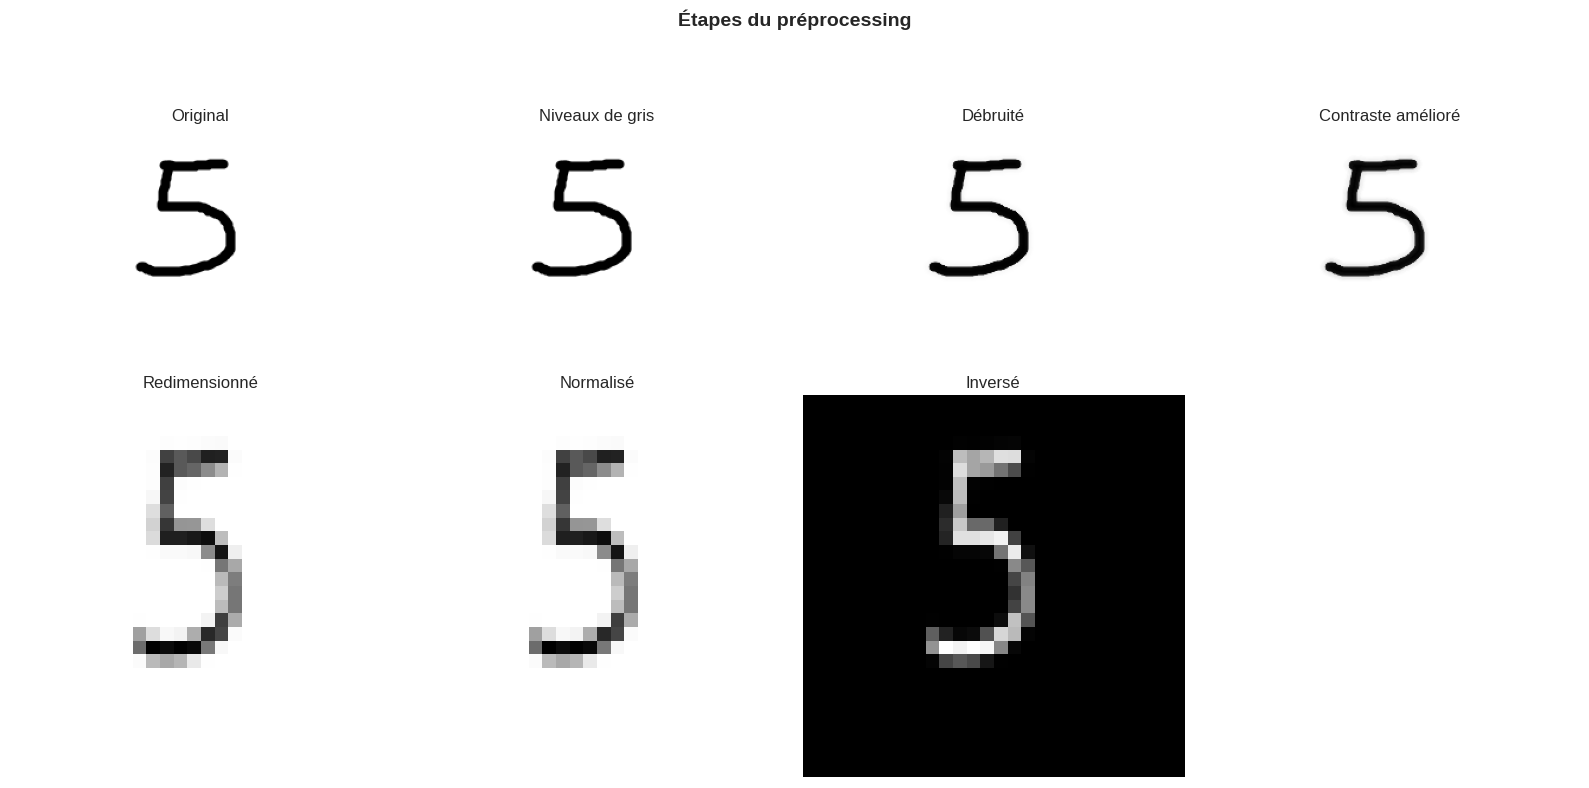

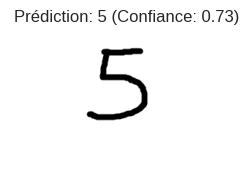

🎯 Chiffre prédit: 5
📊 Confiance: 0.7287
📈 Probabilités détaillées:
   0: 0.0129
   1: 0.0037
   2: 0.0015
   3: 0.0195
   4: 0.0013
   5: 0.7287
   6: 0.0179
   7: 0.0166
   8: 0.1379
   9: 0.0600

🎉 PIPELINE COMPLET TERMINÉ AVEC SUCCÈS! 🎉
Précision finale: 0.9032


In [9]:
# Point d'entrée principal
if __name__ == "__main__":
    # Exécuter le pipeline complet
    trained_recognizer, evaluation_results = complete_training_pipeline()

    # Tester avec des images personnalisées
    test_with_custom_images(trained_recognizer)

    print("\n🎉 PIPELINE COMPLET TERMINÉ AVEC SUCCÈS! 🎉")
    print(f"Précision finale: {evaluation_results['accuracy']:.4f}")


🖼️  TEST AVEC IMAGES PERSONNALISÉES
Téléversez vos images de chiffres...


Saving 3.png to 3 (2).png

Analyse de 3 (2).png:


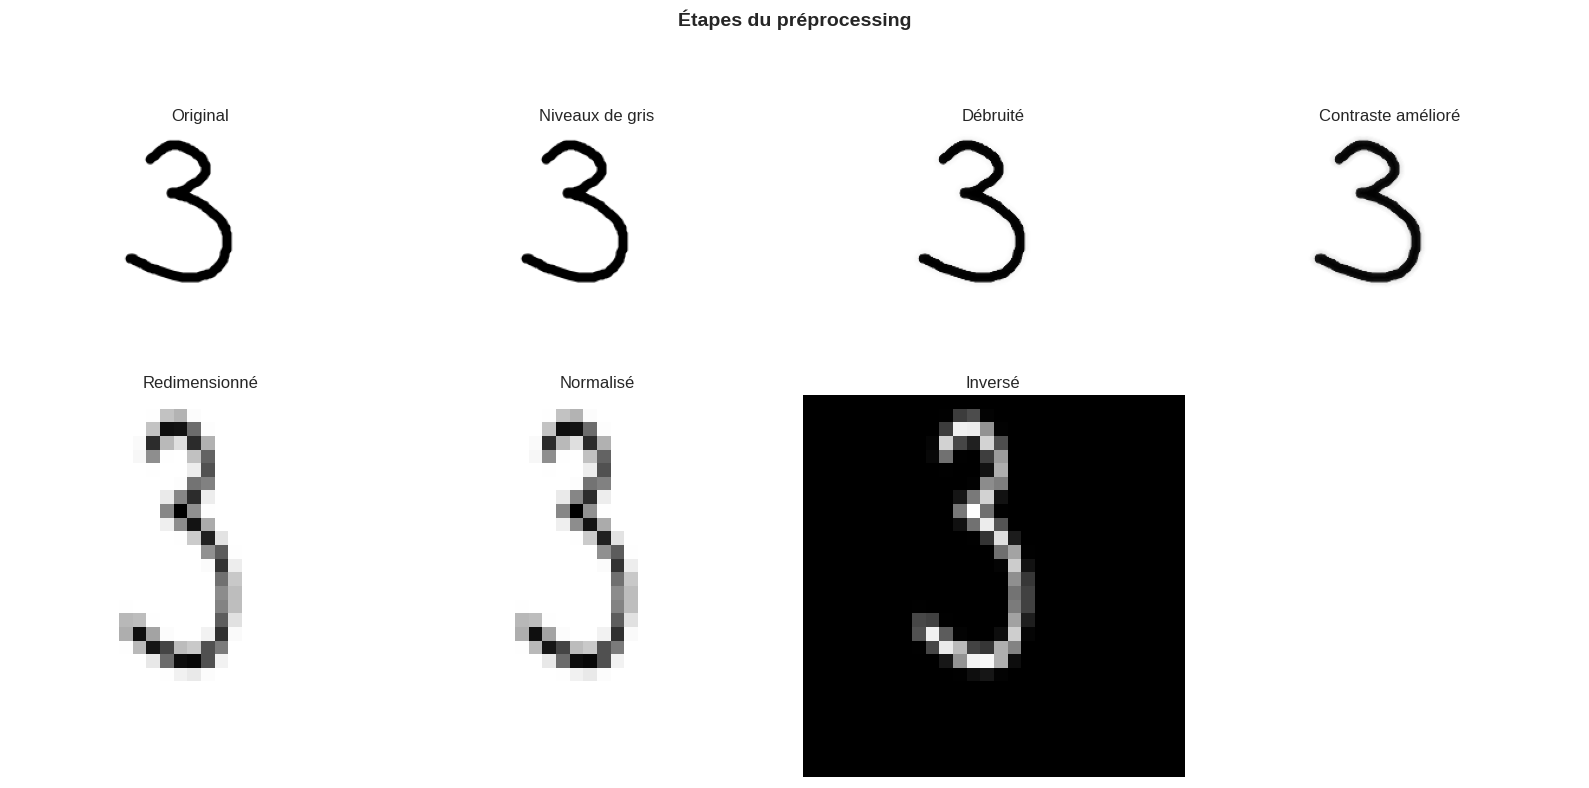

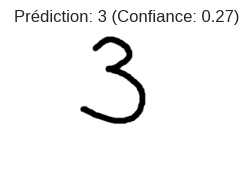

🎯 Chiffre prédit: 3
📊 Confiance: 0.2650
📈 Probabilités détaillées:
   0: 0.0344
   1: 0.0665
   2: 0.0482
   3: 0.2650
   4: 0.0117
   5: 0.0573
   6: 0.0202
   7: 0.1930
   8: 0.1611
   9: 0.1425

🎉 PIPELINE COMPLET TERMINÉ AVEC SUCCÈS! 🎉
Précision finale: 0.9032


In [17]:
    # Tester avec des images personnalisées
    test_with_custom_images(trained_recognizer)

    print("\n🎉 PIPELINE COMPLET TERMINÉ AVEC SUCCÈS! 🎉")
    print(f"Précision finale: {evaluation_results['accuracy']:.4f}")